In [1]:
from platform import python_version

print(python_version())

from IPython.display import display, HTML

display(HTML("<style>.container { width:100% !important; }</style>"))

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.lines import Line2D
from matplotlib import cm
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable

from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import AllChem

from mendeleev import element

#import chemcoord as cc
from scipy import stats
from rdkit import Chem
import seaborn as sns
import pandas as pd
import numpy as np
import shutil
import glob
import csv
import ast
import os
import re
from os.path import exists
import rmsd
import pickle

#sns.set_context('paper', font_scale=1.1)

## CHANGE FOR YOUR COMPUTER ##
comp_loc = '/Users/z5380625/Documents/Research/'

3.10.6


# 4.2 Parsing Vibrational Output Files

## 4.2.1 Finding all Confs and Rotas for each unique molecule

In [2]:
def unique_conf_list(location, loc_num_atoms):
    files_names_confs = glob.glob(
        location + loc_num_atoms +
        '4_VibrationalCalcs/OutputFiles/*.log')

    # Make lists for conformers
    filename_confs_list = [
        (file_vib.split('/')[-1].split('_harmonic')[0].split('_CONF')[0],
         file_vib.split('/')[-1].split('_harmonic')[0].split('_')[-1])
        for file_vib in files_names_confs
    ]

    filename_confs_list = list(zip(*filename_confs_list))

    unique_confs_filenames, unique_confs_counts = np.unique(list(
        filename_confs_list[0]),
                                                            return_counts=True)

    file_conf_comb_list = []
    for unique_mol, unique_count in zip(unique_confs_filenames,
                                        unique_confs_counts):
        conf_indices = np.where(
            np.asarray(filename_confs_list[0]) == unique_mol)[0]
        conf_list = []
        for ind in conf_indices:
            conf_num = np.asarray(filename_confs_list[1])[ind]
            conf_list.append(conf_num)
        if len(conf_list) == unique_count:
            file_conf_comb_list.append((unique_mol, conf_list))

    unique_list = file_conf_comb_list 

    return unique_list

## 4.2.2 Get Harmonic Frequencies from files

In [3]:
def get_harm_info(file):
    inp = open(file, 'r')
    
    chk_count = 0
    for g in inp:
        if 'Normal termination' in g:
            chk_count = chk_count + 1
    inp.close()
    # Continues for output files that terminated normally (they must have 2 'Normal termination')
    if chk_count >= 2:
        # Obtains the raw vibrational data.
        inp = open(file, 'r')
        harm_info = []
        for line in inp:
            line = line.strip()
            if line.startswith('Frequencies --'):
                harm_info.append(line.split())
            elif line.startswith('IR Inten    --'):
                harm_info.append(line.split())
# Prints molecule's name if there are less/more than 2 'Normal termination' in the output file.
    else:
        print(file.split('/')[-1]+' Normal termination problem.')
    inp.close()
    
    return harm_info

## 4.2.3 Get Conf Total Gibbs Energy

In [4]:
def exp_to_sci(x):
    '''From https://stackoverflow.com/questions/50679895/np-expx-when-x-is-small'''
    coeff, exp = np.modf(x / np.log(10.0))
    return 10**(coeff + 1), exp - 1

In [5]:
def get_boltzmannweights_at_T(final_df):
    G_list = final_df['RawG'].values
    for T in [10,50,100,298.15]:
        coeff_list = []
        exp_list = []
        for G in G_list:
            b_exp=float(G/(3.166811563e-6*T))
            coeff,exp = exp_to_sci(-b_exp)
            coeff_list.append(coeff)
            exp_list.append(exp)
        P_list = []
        if exp_list.count(exp_list[0]) == len(exp_list):
            P_list = ["{:.2f}".format(coeff*100/sum(coeff_list)) for coeff in coeff_list]
        elif exp_list.count(exp_list[0]) != len(exp_list):
            n_list = np.max(exp_list)-exp_list
            n_coeff_list = list(zip(n_list,coeff_list))
            
            coeff_list_scaled = [n_coeff[1]/10**n_coeff[0] for n_coeff in n_coeff_list]
            
            P_list = ["{:.2f}".format(coeff*100/sum(coeff_list_scaled)) for coeff in coeff_list_scaled]
        
        col_name= str('BW Percent at '+str(T)+' K')
        final_df[col_name] = P_list
    return

In [6]:
def int_get_gibbs_energy(location,loc_num_atoms,mol_id,CONF,conf,energy_df):
    file = location+loc_num_atoms+'3_CREST_CENSO_Outputs/BWeights_GeomFiles_'+CONF+'/'+mol_id+'_bweight_'+conf+'.dat'
    print(file)
    if os.path.exists(file) == True:
        inp = open(file, 'r')
        
        energy_info = []
        for line in inp:
            line = line.strip()
            if line.startswith('CONF'):
                energy_info.append(line.split())
        for row in energy_info:
            if energy_info.index(row) > 0:
                if 'Conf' in CONF: 
                    energy_df.loc[len(energy_df)] = [row[0],float(row[5])*627.509*4.184,float(row[5])] # 4.184 is the conversion factor to kJ/mol
    return energy_df

In [7]:
def get_censo_gibbs_energy(location,loc_num_atoms,mol_id):
    energy_df = pd.DataFrame(columns = ['CONF#','G','RawG'])
    CONF = 'Conformers'
    conf = 'conformers'
    
    final_df = int_get_gibbs_energy(location,loc_num_atoms,mol_id,CONF,conf,energy_df)
        
    
    final_df = final_df.sort_values('G')
    min_energy = np.min(final_df['G'].values)
    final_df['G'] = final_df['G'] - min_energy

    get_boltzmannweights_at_T(final_df)
    
    return final_df

In [9]:
df = get_censo_gibbs_energy('/Users/z5380625/Documents/Research/4_BigData/','6_Atoms/','C2H2')
df

/Users/z5380625/Documents/Research/4_BigData/6_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C2H2_bweight_conformers.dat


,CONF#,G,RawG,BW Percent at 10 K,BW Percent at 50 K,BW Percent at 100 K,BW Percent at 298.15 K
0,CONF1,0.0,-77.454779,100.00,100.00,100.00,100.00


## 4.2.4 Get Dipole Moments

In [10]:
def get_dipole_moments(file):
    
    dipole_info = []
    rotmatrix_info = []
    mat_count = 0
    with open(file, 'r') as inp:
        for line in inp:
            line = line.strip()

            if line.startswith('Dipole moment (Debye):'):
                #print(next(inp).split())
                dipole_info.append(next(inp).split())
            if line.startswith('Rotation matrix to Principal Axis frame:'):
                mat_count+=1
                if mat_count==2:
                    rotmatrix_info.append(next(inp).split())
                    rotmatrix_info.append(next(inp).split())
                    rotmatrix_info.append(next(inp).split())
                    rotmatrix_info.append(next(inp).split())
        
    row = dipole_info[-1]
    xyz_dipole = [float(row[0]),float(row[1]),float(row[2])]
    rotmatrix_info.remove(['1', '2', '3'])

    rot_matrix = []
    for row in rotmatrix_info:
        rot_matrix.append([float(row[1].replace('D','E')),float(row[2].replace('D','E')),float(row[3].replace('D','E'))])
    abc_dipole = np.matmul(rot_matrix,xyz_dipole)
    
    return np.append(abc_dipole,[np.sqrt(abc_dipole[0]**2+abc_dipole[1]**2+abc_dipole[2]**2),abc_dipole[0]*abc_dipole[1]*abc_dipole[2]])

## 4.2.5 Get Rotational Constants A,B,C

In [11]:
def get_rotational_constants(file):
    rot_count = 0
    with open(file, 'r') as inp:
        for line in inp:
            line = line.strip()
            if line.startswith('Rotational constants (MHZ):'):
                rot_count+=1
                if rot_count==2:
                    rot_info=next(inp).split()
    if (rot_info[0] == '***************'):
        rot_info[0] = 0
    elif (rot_info[1] == '***************'):
        rot_info[1] = 0
    elif (rot_info[2] == '***************'):
        rot_info[2] = 0
        
    return [float(rot_info[0])/29979.2458,float(rot_info[1])/29979.2458,float(rot_info[2])/29979.2458]

## 4.2.6 Get Rotamer Degeneracy

In [12]:
def get_rotamer_degeneracy(location,loc_num_atoms,mol_id,conf):
    file_crest = location+loc_num_atoms+'3_CREST_CENSO_Outputs/CREST_OutputFiles/'+mol_id+'_crest.out'
    degen_info_list = []
    with open(file_crest, 'r') as inp:
        for line in inp:
            line = line.strip()
            if line.startswith('Erel/kcal'):
                while not all(i in ['T', '/K', ':', '298.15'] for i in line):
                    line=next(inp).split()
                    degen_info_list.append(line)     
    inp.close()
    
    conf_num = conf.split('CONF')[-1]
    rota_degen=1
    for line in degen_info_list:
        if len(line)==8:
            if conf_num==line[-3]:
                rota_degen = line[-2]
    print(mol_id,conf_num,rota_degen)            
    return rota_degen
    

In [13]:
location = comp_loc+'4_BigData/'
file_conf_list=unique_conf_list(location,'11_Atoms/')
for mol in file_conf_list:
        mol_id = mol[0]
        mol_conf = mol[1]
        if mol_id == 'C2H5N3O_1':
            print(mol_id,mol_conf)
            get_rotamer_degeneracy(location,'11_Atoms/','C2H5N3O_1','CONF1')

C2H5N3O_1 ['CONF11', 'CONF1', 'CONF2', 'CONF6', 'CONF8', 'CONF3', 'CONF13']
C2H5N3O_1 1 2


## 4.2.7 Get Vib Data from Output Files

In [14]:
# -------------------------------------------
# Parsing Vibrational Data from Output Files
# -------------------------------------------

def int_parse_vib_data(location,loc_num_atoms,biosig_data,df):
    file_conf_list=unique_conf_list(location,loc_num_atoms)

    # Opens each individual output file as reference for the SMILES codes.
    for mol in file_conf_list:
        mol_id = mol[0]
        mol_conf = mol[1]
        

        # Gets the SMILES code and the experimental frequencies from the benchmark dataset.
        smiles_code = biosig_data.query("Formula_ID == @mol_id")['SMILES'].iloc[0] 
        mol_tot_atoms = int(biosig_data.loc[biosig_data['Formula_ID'] == mol_id]['Tot_atoms'].values[0])

        # Gets dataframe with gibbs energy for each Conf
        energy_df = get_censo_gibbs_energy(location,loc_num_atoms,mol_id)

        inter_row_info_list = []
        for conf in mol_conf:
            
            # get Gibbs energies
            conf_energy = energy_df.loc[energy_df['CONF#'] == conf]['G'].values[0]
            conf_bw_10K = energy_df.loc[energy_df['CONF#'] == conf]['BW Percent at 10 K'].values[0]
            conf_bw_50K = energy_df.loc[energy_df['CONF#'] == conf]['BW Percent at 50 K'].values[0]
            conf_bw_100K = energy_df.loc[energy_df['CONF#'] == conf]['BW Percent at 100 K'].values[0]
            conf_bw_29815K = energy_df.loc[energy_df['CONF#'] == conf]['BW Percent at 298.15 K'].values[0]

            conf_type = re.split('(\d+)',conf)[0]

            if conf_type == 'CONF':
                file = location+loc_num_atoms+'4_VibrationalCalcs/OutputFiles/'+mol_id+'_'+conf+'_harmonic_conformers.log'

            # get harmonic frequencies from 'file' for specific Conf
            harm_info = get_harm_info(file)


            conf_raw_freqs = []
            conf_scaled_freqs = []
            conf_ints = []

            for line_data in harm_info:
                # From the raw vibrational data obatins the frequencies and modes.
                if line_data[0] == 'Frequencies':
                    for index,value in enumerate(line_data):
                        if index > 1:
                            #counter += 1
                            conf_raw_freqs.append(float(value))
                            #hmodes.append(str(counter))

                # From the raw vibrational data obtained the intensities.
                elif line_data[0] == 'IR':
                    for index,value in enumerate(line_data):
                        if index > 2:
                            conf_ints.append(float(value))


            # test for imaginary frequencies.
            neg_freqs = 0
            for freq in conf_raw_freqs:
                if float(freq) < 0:
                    neg_freqs = neg_freqs + 1

            scale_factors = [0.995395864,0.979158827,0.963816253] #[low,mid,high] #B971/Def2TZVPD
            # If no imaginary frequencies, prints data into a dataframe (later csv file).
            if neg_freqs == 0:
                conf_scaled_freqs = []
                for freq in conf_raw_freqs:
                    if freq < 1000:
                        freq_scaled = freq*scale_factors[0]
                    elif (freq >= 1000) and (freq <= 2000):
                        freq_scaled = freq*scale_factors[1]
                    elif freq > 2000:
                        freq_scaled = freq*scale_factors[2]
                    conf_scaled_freqs.append(freq_scaled)

                # Get dipole moments
                dipole_info = get_dipole_moments(file)
                
                # Get Rotational Constants in cm-1
                #print(file)
                rot_info = get_rotational_constants(file)
                
                # Get rotamer degeneracy
                rota_degen = get_rotamer_degeneracy(location,loc_num_atoms,mol_id,conf)

                # Make each row of data
                row_info = list([mol_id,smiles_code,mol_tot_atoms,conf,rota_degen,conf_energy,conf_bw_10K,conf_bw_50K,conf_bw_100K,conf_bw_29815K,conf_raw_freqs,conf_scaled_freqs,conf_ints,dipole_info[0],dipole_info[1],dipole_info[2],dipole_info[3],dipole_info[4],rot_info[0],rot_info[1],rot_info[2]])
                df.loc[len(df)] = row_info

            # If imaginary frequency found, prints the name of the molecule.
            
            else:
                print(file.split('/')[-1]+' has imaginary frequencies.')
    return df

In [15]:
def parse_vib_data(location,biosig_data,df):
    files_list = glob.glob(comp_loc+'4_BigData/?_Atoms')+glob.glob(comp_loc+'4_BigData/??_Atoms')
    files_list.remove(comp_loc+'4_BigData/21_Atoms')# Not Complete yet
    print(files_list)
    for file in files_list:
        loc_num_atoms = file.split('/')[-1]+'/'
        int_parse_vib_data(location,loc_num_atoms,biosig_data,df)
    return

    

In [16]:
## Change for your computer ##
location = comp_loc+'4_BigData/'

# Get biosig data 
biosig_data = pd.read_csv(location+'11_Atoms/biosig_data.csv')

df = pd.DataFrame(columns = ['Formula','SMILES','# Atoms','Conf#','Rotamer Degeneracy','Relative Energy [kJ/mol]','BW Percent at 10 K','BW Percent at 50 K','BW Percent at 100 K','BW Percent at 298.15 K','RawFreq [cm-1]','ScaledFreq [cm-1]','Intensity','mu_a [D]','mu_b [D]','mu_c [D]','mu_tot [D]','mu_amu_bmu_c','A [cm-1]', 'B [cm-1]','C [cm-1]'])

parse_vib_data(location,biosig_data,df)

['/Users/z5380625/Documents/Research/4_BigData/6_Atoms', '/Users/z5380625/Documents/Research/4_BigData/9_Atoms', '/Users/z5380625/Documents/Research/4_BigData/8_Atoms', '/Users/z5380625/Documents/Research/4_BigData/18_Atoms', '/Users/z5380625/Documents/Research/4_BigData/19_Atoms', '/Users/z5380625/Documents/Research/4_BigData/20_Atoms', '/Users/z5380625/Documents/Research/4_BigData/13_Atoms', '/Users/z5380625/Documents/Research/4_BigData/11_Atoms', '/Users/z5380625/Documents/Research/4_BigData/15_Atoms', '/Users/z5380625/Documents/Research/4_BigData/17_Atoms', '/Users/z5380625/Documents/Research/4_BigData/10_Atoms', '/Users/z5380625/Documents/Research/4_BigData/12_Atoms', '/Users/z5380625/Documents/Research/4_BigData/16_Atoms', '/Users/z5380625/Documents/Research/4_BigData/14_Atoms']
/Users/z5380625/Documents/Research/4_BigData/6_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C2H2_bweight_conformers.dat
C2H2 1 1
/Users/z5380625/Documents/Research/4_BigData/6_Atoms/3_CREST_C

CHNS 1 1
/Users/z5380625/Documents/Research/4_BigData/6_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/CN2O3_bweight_conformers.dat
CN2O3 1 1
/Users/z5380625/Documents/Research/4_BigData/6_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/CN2OS_bweight_conformers.dat
CN2OS 2 1
CN2OS 1 1
/Users/z5380625/Documents/Research/4_BigData/6_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/CN2O_2_bweight_conformers.dat
CN2O_2 1 1
/Users/z5380625/Documents/Research/4_BigData/6_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/CO_bweight_conformers.dat
CO 1 1
/Users/z5380625/Documents/Research/4_BigData/6_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/CO2_bweight_conformers.dat
CO2 1 1
/Users/z5380625/Documents/Research/4_BigData/6_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/COS_bweight_conformers.dat
COS 1 1
/Users/z5380625/Documents/Research/4_BigData/6_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/CS2_bweight_conformers.d

C2H4O3_2 1 3
/Users/z5380625/Documents/Research/4_BigData/9_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C2H4O3_3_bweight_conformers.dat
C2H4O3_3 1 3
/Users/z5380625/Documents/Research/4_BigData/9_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C2H4OS2_2_bweight_conformers.dat
C2H4OS2_2 6 1
/Users/z5380625/Documents/Research/4_BigData/9_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C2H4OS2_3_bweight_conformers.dat
C2H4OS2_3 3 2
C2H4OS2_3 7 2
C2H4OS2_3 8 1
C2H4OS2_3 4 2
C2H4OS2_3 2 2
C2H4OS2_3 1 1
/Users/z5380625/Documents/Research/4_BigData/9_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C2H4OS2_4_bweight_conformers.dat
C2H4OS2_4 3 2
C2H4OS2_4 4 2
C2H4OS2_4 2 2
C2H4OS2_4 1 2
/Users/z5380625/Documents/Research/4_BigData/9_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C2H4OS2_5_bweight_conformers.dat
C2H4OS2_5 1 3
C2H4OS2_5 2 3
/Users/z5380625/Documents/Research/4_BigData/9_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformer

C3H3NOS_6 2 1
C3H3NOS_6 1 1
/Users/z5380625/Documents/Research/4_BigData/9_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C3H3NOS_7_bweight_conformers.dat
C3H3NOS_7 2 1
/Users/z5380625/Documents/Research/4_BigData/9_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C3H3NOS_8_bweight_conformers.dat
C3H3NOS_8 1 1
/Users/z5380625/Documents/Research/4_BigData/9_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C3H3NOS_9_bweight_conformers.dat
C3H3NOS_9 1 1
/Users/z5380625/Documents/Research/4_BigData/9_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C3H3NS2_1_bweight_conformers.dat
C3H3NS2_1 2 1
C3H3NS2_1 1 1
C3H3NS2_1 3 1
C3H3NS2_1 4 1
/Users/z5380625/Documents/Research/4_BigData/9_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C3H3NS2_2_bweight_conformers.dat
C3H3NS2_2 2 1
/Users/z5380625/Documents/Research/4_BigData/9_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C3H3NS2_3_bweight_conformers.dat
C3H3NS2_3 2 3
C3H3NS2_3 1 3
/Use

C4H3NS_2 1 3
/Users/z5380625/Documents/Research/4_BigData/9_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C4H3NS_3_bweight_conformers.dat
C4H3NS_3 2 1
C4H3NS_3 1 1
/Users/z5380625/Documents/Research/4_BigData/9_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C4H3NS_4_bweight_conformers.dat
C4H3NS_4 1 3
/Users/z5380625/Documents/Research/4_BigData/9_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C4H3NS_5_bweight_conformers.dat
C4H3NS_5 1 1
/Users/z5380625/Documents/Research/4_BigData/9_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C4H3NS_6_bweight_conformers.dat
C4H3NS_6 2 1
C4H3NS_6 1 2
/Users/z5380625/Documents/Research/4_BigData/9_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C4H3OP_bweight_conformers.dat
C4H3OP 1 1
/Users/z5380625/Documents/Research/4_BigData/9_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C4H4O_1_bweight_conformers.dat
C4H4O_1 1 1
C4H4O_1 2 1
/Users/z5380625/Documents/Research/4_BigData/9_Atoms/3_

H4NO2PS 3 2
H4NO2PS 2 4
H4NO2PS 1 4
/Users/z5380625/Documents/Research/4_BigData/9_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/H4NO3P_bweight_conformers.dat
H4NO3P 6 2
H4NO3P 1 4
/Users/z5380625/Documents/Research/4_BigData/8_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C2H2N2O2_bweight_conformers.dat
C2H2N2O2 1 1
/Users/z5380625/Documents/Research/4_BigData/8_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C2H2N2OS_1_bweight_conformers.dat
C2H2N2OS_1 1 1
/Users/z5380625/Documents/Research/4_BigData/8_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C2H2N2OS_2_bweight_conformers.dat
C2H2N2OS_2 1 1
/Users/z5380625/Documents/Research/4_BigData/8_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C2H2N2OS_3_bweight_conformers.dat
C2H2N2OS_3 1 1
/Users/z5380625/Documents/Research/4_BigData/8_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C2H2N2OS_4_bweight_conformers.dat
C2H2N2OS_4 1 1
/Users/z5380625/Documents/Research/4_BigD

C2H3NS_3 1 3
C2H3NS_3 2 1
/Users/z5380625/Documents/Research/4_BigData/8_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C2H3O2P_1_bweight_conformers.dat
C2H3O2P_1 1 1
/Users/z5380625/Documents/Research/4_BigData/8_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C2H3O2P_2_bweight_conformers.dat
C2H3O2P_2 3 1
C2H3O2P_2 2 2
/Users/z5380625/Documents/Research/4_BigData/8_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C2H3OP_1_bweight_conformers.dat
C2H3OP_1 2 1
C2H3OP_1 1 1
/Users/z5380625/Documents/Research/4_BigData/8_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C2H3OP_2_bweight_conformers.dat
C2H3OP_2 1 1
/Users/z5380625/Documents/Research/4_BigData/8_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C2H4N2_1_bweight_conformers.dat
C2H4N2_1 2 4
C2H4N2_1 1 2
/Users/z5380625/Documents/Research/4_BigData/8_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C2H4N2_2_bweight_conformers.dat
C2H4N2_2 1 3
C2H4N2_2 2 1
/Users/z5380625/D

C3H2O3_2 1 1
C3H2O3_2 2 2
/Users/z5380625/Documents/Research/4_BigData/8_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C3H2O3_3_bweight_conformers.dat
C3H2O3_3 1 1
/Users/z5380625/Documents/Research/4_BigData/8_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C3H2O3_4_bweight_conformers.dat
C3H2O3_4 1 1
/Users/z5380625/Documents/Research/4_BigData/8_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C3H2OS_bweight_conformers.dat
C3H2OS 1 1
/Users/z5380625/Documents/Research/4_BigData/8_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C3H2OS2_1_bweight_conformers.dat
C3H2OS2_1 1 1
/Users/z5380625/Documents/Research/4_BigData/8_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C3H3NO_1_bweight_conformers.dat
C3H3NO_1 1 3
/Users/z5380625/Documents/Research/4_BigData/8_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C3H3NO_2_bweight_conformers.dat
C3H3NO_2 2 1
C3H3NO_2 1 1
/Users/z5380625/Documents/Research/4_BigData/8_Atoms/3_CREST_CE

CH2N4O_1 1 1
/Users/z5380625/Documents/Research/4_BigData/8_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/CH2N4O_2_bweight_conformers.dat
CH2N4O_2 1 1
/Users/z5380625/Documents/Research/4_BigData/8_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/CH2N4O_3_bweight_conformers.dat
CH2N4O_3 1 1
CH2N4O_3 2 1
/Users/z5380625/Documents/Research/4_BigData/8_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/CH2N4S_1_bweight_conformers.dat
CH2N4S_1 1 2
/Users/z5380625/Documents/Research/4_BigData/8_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/CH2N4S_2_bweight_conformers.dat
CH2N4S_2 2 1
/Users/z5380625/Documents/Research/4_BigData/8_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/CH2N4S_3_bweight_conformers.dat
CH2N4S_3 1 1
CH2N4S_3 3 1
/Users/z5380625/Documents/Research/4_BigData/8_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/CH2N4_1_bweight_conformers.dat
CH2N4_1 1 1
/Users/z5380625/Documents/Research/4_BigData/8_Atoms/3_CREST_CE

H3O2PS 1 1
H3O2PS 3 1
/Users/z5380625/Documents/Research/4_BigData/8_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/H3O3P_bweight_conformers.dat
H3O3P 2 2
H3O3P 1 1
/Users/z5380625/Documents/Research/4_BigData/8_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/H3O3PS_bweight_conformers.dat
H3O3PS 2 3
H3O3PS 1 2
/Users/z5380625/Documents/Research/4_BigData/8_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/H3O4P_bweight_conformers.dat
H3O4P 3 1
H3O4P 1 3
H3O4P 2 2
/Users/z5380625/Documents/Research/4_BigData/8_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/H3OPS2_bweight_conformers.dat
H3OPS2 2 2
H3OPS2 1 1
/Users/z5380625/Documents/Research/4_BigData/8_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/H4N2OS_1_bweight_conformers.dat
H4N2OS_1 7 2
H4N2OS_1 3 1
H4N2OS_1 2 2
H4N2OS_1 6 2
H4N2OS_1 5 2
H4N2OS_1 1 2
/Users/z5380625/Documents/Research/4_BigData/8_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/H4N2OS_2_bweight_conformer

C4H12N2_6 10 31
C4H12N2_6 9 9
C4H12N2_6 12 1
C4H12N2_6 11 4
C4H12N2_6 3 7
/Users/z5380625/Documents/Research/4_BigData/18_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C4H12N2_7_bweight_conformers.dat
C4H12N2_7 2 16
C4H12N2_7 9 14
C4H12N2_7 5 16
C4H12N2_7 1 20
C4H12N2_7 7 17
C4H12N2_7 3 17
/Users/z5380625/Documents/Research/4_BigData/18_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C4H12N2_8_bweight_conformers.dat
C4H12N2_8 27 5
C4H12N2_8 2 13
C4H12N2_8 28 4
C4H12N2_8 16 9
C4H12N2_8 45 2
C4H12N2_8 34 15
C4H12N2_8 9 1
C4H12N2_8 12 6
C4H12N2_8 23 12
C4H12N2_8 6 17
C4H12N2_8 30 4
C4H12N2_8 42 5
C4H12N2_8 20 9
C4H12N2_8 5 1
C4H12N2_8 15 10
C4H12N2_8 7 6
C4H12N2_8 22 1
C4H12N2_8 29 1
C4H12N2_8 26 6
/Users/z5380625/Documents/Research/4_BigData/18_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C4H12N2_9_bweight_conformers.dat
C4H12N2_9 1 53
C4H12N2_9 2 52
C4H12N2_9 4 25
C4H12N2_9 3 63
/Users/z5380625/Documents/Research/4_BigData/18_Atoms/3_CREST_CENSO_Output

C5H12S_8 18 1
C5H12S_8 44 9
/Users/z5380625/Documents/Research/4_BigData/18_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C5H12S_9_bweight_conformers.dat
C5H12S_9 1 53
C5H12S_9 5 50
C5H12S_9 6 22
C5H12S_9 2 1
C5H12S_9 4 49
C5H12S_9 3 42
/Users/z5380625/Documents/Research/4_BigData/18_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C6H12_1_bweight_conformers.dat
C6H12_1 1 27
/Users/z5380625/Documents/Research/4_BigData/18_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C6H12_10_bweight_conformers.dat
C6H12_10 1 18
C6H12_10 6 6
C6H12_10 2 18
C6H12_10 4 9
C6H12_10 3 18
/Users/z5380625/Documents/Research/4_BigData/18_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C6H12_11_bweight_conformers.dat
C6H12_11 16 2
/Users/z5380625/Documents/Research/4_BigData/18_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C6H12_12_bweight_conformers.dat
C6H12_12 1 81
/Users/z5380625/Documents/Research/4_BigData/18_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFi

C5H13N_6 3 33
C5H13N_6 4 49
C5H13N_6 2 50
C5H13N_6 1 47
C5H13N_6 5 41
/Users/z5380625/Documents/Research/4_BigData/19_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C5H13N_7_bweight_conformers.dat
C5H13N_7 1 308
/Users/z5380625/Documents/Research/4_BigData/19_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C5H13N_8_bweight_conformers.dat
C5H13N_8 3 76
C5H13N_8 1 48
C5H13N_8 2 95
/Users/z5380625/Documents/Research/4_BigData/19_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C5H13N_9_bweight_conformers.dat
C5H13N_9 2 82
C5H13N_9 1 271
/Users/z5380625/Documents/Research/4_BigData/19_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C5H13P_1_bweight_conformers.dat
C5H13P_1 18 7
C5H13P_1 26 7
C5H13P_1 17 5
C5H13P_1 8 8
C5H13P_1 7 8
C5H13P_1 22 9
C5H13P_1 3 9
C5H13P_1 10 9
C5H13P_1 21 7
C5H13P_1 14 7
C5H13P_1 12 4
C5H13P_1 6 8
C5H13P_1 9 7
C5H13P_1 16 6
C5H13P_1 27 5
C5H13P_1 15 6
C5H13P_1 5 1
C5H13P_1 20 6
C5H13P_1 11 8
C5H13P_1 1 9
/Users/z5380625/Doc

C2H7NO2S_5 2 6
C2H7NO2S_5 1 12
C2H7NO2S_5 5 6
C2H7NO2S_5 4 12
/Users/z5380625/Documents/Research/4_BigData/13_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C2H7NO2S_6_bweight_conformers.dat
C2H7NO2S_6 4 1
C2H7NO2S_6 3 18
/Users/z5380625/Documents/Research/4_BigData/13_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C2H7O2PS_1_bweight_conformers.dat
C2H7O2PS_1 2 3
C2H7O2PS_1 1 10
/Users/z5380625/Documents/Research/4_BigData/13_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C2H7O2PS_2_bweight_conformers.dat
C2H7O2PS_2 5 9
C2H7O2PS_2 2 2
C2H7O2PS_2 4 18
/Users/z5380625/Documents/Research/4_BigData/13_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C2H7O2PS_3_bweight_conformers.dat
C2H7O2PS_3 2 9
C2H7O2PS_3 1 9
/Users/z5380625/Documents/Research/4_BigData/13_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C2H7O3P_1_bweight_conformers.dat
C2H7O3P_1 2 3
C2H7O3P_1 4 1
C2H7O3P_1 3 3
/Users/z5380625/Documents/Research/4_BigData/13_Atoms/3_CRE

C3H7NOS_4 9 3
C3H7NOS_4 33 3
C3H7NOS_4 6 3
C3H7NOS_4 2 3
C3H7NOS_4 19 3
C3H7NOS_4 1 3
C3H7NOS_4 23 3
C3H7NOS_4 30 3
C3H7NOS_4 25 3
C3H7NOS_4 14 3
C3H7NOS_4 3 3
C3H7NOS_4 10 3
C3H7NOS_4 7 3
C3H7NOS_4 32 3
C3H7NOS_4 8 3
C3H7NOS_4 31 1
C3H7NOS_4 13 3
C3H7NOS_4 22 3
C3H7NOS_4 26 2
C3H7NOS_4 17 3
/Users/z5380625/Documents/Research/4_BigData/13_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C3H7NOS_5_bweight_conformers.dat
C3H7NOS_5 1 2
C3H7NOS_5 2 2
C3H7NOS_5 4 2
C3H7NOS_5 8 2
C3H7NOS_5 7 1
/Users/z5380625/Documents/Research/4_BigData/13_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C3H7NOS_6_bweight_conformers.dat
C3H7NOS_6 2 3
C3H7NOS_6 1 6
/Users/z5380625/Documents/Research/4_BigData/13_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C3H7NS2_1_bweight_conformers.dat
C3H7NS2_1 7 4
C3H7NS2_1 2 4
C3H7NS2_1 1 4
C3H7NS2_1 5 2
/Users/z5380625/Documents/Research/4_BigData/13_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C3H7NS2_2_bweight_conformers.d

C3H8OS_6 4 6
C3H8OS_6 9 6
C3H8OS_6 6 6
C3H8OS_6 1 6
C3H8OS_6 10 6
/Users/z5380625/Documents/Research/4_BigData/13_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C3H8OS_7_bweight_conformers.dat
C3H8OS_7 3 9
C3H8OS_7 1 9
C3H8OS_7 2 9
/Users/z5380625/Documents/Research/4_BigData/13_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C3H8S2_2_bweight_conformers.dat
C3H8S2_2 14 3
C3H8S2_2 1 6
C3H8S2_2 10 6
C3H8S2_2 5 6
C3H8S2_2 6 6
C3H8S2_2 9 6
C3H8S2_2 13 6
C3H8S2_2 4 6
C3H8S2_2 19 6
C3H8S2_2 3 6
C3H8S2_2 23 1
C3H8S2_2 7 1
/Users/z5380625/Documents/Research/4_BigData/13_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C3H8S2_3_bweight_conformers.dat
C3H8S2_3 1 18
C3H8S2_3 3 4
/Users/z5380625/Documents/Research/4_BigData/13_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C3H8S2_4_bweight_conformers.dat
C3H8S2_4 14 3
C3H8S2_4 2 3
C3H8S2_4 21 6
C3H8S2_4 5 3
C3H8S2_4 26 3
C3H8S2_4 18 3
C3H8S2_4 17 3
C3H8S2_4 7 3
C3H8S2_4 8 3
C3H8S2_4 20 3
C3H8S2_4 16 3
C3H8S

C4H7NO_37 2 2
C4H7NO_37 5 1
C4H7NO_37 1 2
/Users/z5380625/Documents/Research/4_BigData/13_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C4H7NO_38_bweight_conformers.dat
C4H7NO_38 1 2
/Users/z5380625/Documents/Research/4_BigData/13_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C4H7NO_39_bweight_conformers.dat
C4H7NO_39 1 6
C4H7NO_39 2 3
/Users/z5380625/Documents/Research/4_BigData/13_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C4H7NO_4_bweight_conformers.dat
C4H7NO_4 1 6
/Users/z5380625/Documents/Research/4_BigData/13_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C4H7NO_40_bweight_conformers.dat
C4H7NO_40 1 1
C4H7NO_40 2 2
/Users/z5380625/Documents/Research/4_BigData/13_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C4H7NO_41_bweight_conformers.dat
C4H7NO_41 6 1
C4H7NO_41 1 1
C4H7NO_41 3 1
C4H7NO_41 4 1
/Users/z5380625/Documents/Research/4_BigData/13_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C4H7NO_42_bweight_c

C4H8O_14 3 18
C4H8O_14 4 18
C4H8O_14 6 6
/Users/z5380625/Documents/Research/4_BigData/13_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C4H8O_15_bweight_conformers.dat
C4H8O_15 4 6
C4H8O_15 3 6
C4H8O_15 1 6
C4H8O_15 2 3
/Users/z5380625/Documents/Research/4_BigData/13_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C4H8O_16_bweight_conformers.dat
C4H8O_16 2 2
C4H8O_16 1 1
/Users/z5380625/Documents/Research/4_BigData/13_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C4H8O_17_bweight_conformers.dat
C4H8O_17 1 2
C4H8O_17 5 1
C4H8O_17 2 2
C4H8O_17 4 2
C4H8O_17 3 2
/Users/z5380625/Documents/Research/4_BigData/13_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C4H8O_18_bweight_conformers.dat
C4H8O_18 1 3
C4H8O_18 3 6
/Users/z5380625/Documents/Research/4_BigData/13_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C4H8O_19_bweight_conformers.dat
C4H8O_19 3 2
/Users/z5380625/Documents/Research/4_BigData/13_Atoms/3_CREST_CENSO_Outputs/BWeights_Ge

C5H7N_3 3 1
C5H7N_3 2 1
C5H7N_3 1 1
/Users/z5380625/Documents/Research/4_BigData/13_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C5H7N_4_bweight_conformers.dat
C5H7N_4 7 1
C5H7N_4 10 1
C5H7N_4 3 1
C5H7N_4 4 1
C5H7N_4 2 1
C5H7N_4 6 1
C5H7N_4 5 1
C5H7N_4 1 1
/Users/z5380625/Documents/Research/4_BigData/13_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C5H7N_5_bweight_conformers.dat
C5H7N_5 2 1
/Users/z5380625/Documents/Research/4_BigData/13_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C5H7N_6_bweight_conformers.dat
C5H7N_6 1 3
/Users/z5380625/Documents/Research/4_BigData/13_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C5H7N_8_bweight_conformers.dat
C5H7N_8 1 1
C5H7N_8 2 1
/Users/z5380625/Documents/Research/4_BigData/13_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C5H7N_9_bweight_conformers.dat
C5H7N_9 1 3
/Users/z5380625/Documents/Research/4_BigData/13_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C5H7P_1_bweight_

/Users/z5380625/Documents/Research/4_BigData/11_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C2H5NO3_2_bweight_conformers.dat
C2H5NO3_2 1 2
C2H5NO3_2 9 1
C2H5NO3_2 2 2
/Users/z5380625/Documents/Research/4_BigData/11_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C2H5NO3_3_bweight_conformers.dat
C2H5NO3_3 6 2
C2H5NO3_3 2 2
C2H5NO3_3 1 2
C2H5NO3_3 5 2
C2H5NO3_3 3 2
C2H5NO3_3 8 2
C2H5NO3_3 7 2
C2H5NO3_3 4 2
C2H5NO3_3 10 2
/Users/z5380625/Documents/Research/4_BigData/11_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C2H5NO3_4_bweight_conformers.dat
C2H5NO3_4 2 1
C2H5NO3_4 9 4
C2H5NO3_4 5 4
C2H5NO3_4 10 2
/Users/z5380625/Documents/Research/4_BigData/11_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C2H5NO3_5_bweight_conformers.dat
C2H5NO3_5 1 4
/Users/z5380625/Documents/Research/4_BigData/11_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C2H5NO3_6_bweight_conformers.dat
C2H5NO3_6 2 6
C2H5NO3_6 1 12
/Users/z5380625/Documents/Research/4

C2H7OP_1 9 2
C2H7OP_1 12 1
C2H7OP_1 4 2
C2H7OP_1 7 2
C2H7OP_1 3 2
/Users/z5380625/Documents/Research/4_BigData/11_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C2H7OP_2_bweight_conformers.dat
C2H7OP_2 2 9
C2H7OP_2 1 9
/Users/z5380625/Documents/Research/4_BigData/11_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C2H7OP_3_bweight_conformers.dat
C2H7OP_3 4 9
C2H7OP_3 3 3
C2H7OP_3 1 9
C2H7OP_3 6 1
/Users/z5380625/Documents/Research/4_BigData/11_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C2H7OP_4_bweight_conformers.dat
C2H7OP_4 1 3
C2H7OP_4 2 6
/Users/z5380625/Documents/Research/4_BigData/11_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C2H7PS_bweight_conformers.dat
C2H7PS 1 6
C2H7PS 2 6
C2H7PS 4 1
/Users/z5380625/Documents/Research/4_BigData/11_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C3H5N3_1_bweight_conformers.dat
C3H5N3_1 2 1
C3H5N3_1 1 1
/Users/z5380625/Documents/Research/4_BigData/11_Atoms/3_CREST_CENSO_Outputs/BWeight

C3H5O2P_4 2 3
/Users/z5380625/Documents/Research/4_BigData/11_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C3H5O2P_5_bweight_conformers.dat
C3H5O2P_5 2 3
/Users/z5380625/Documents/Research/4_BigData/11_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C3H5O2P_6_bweight_conformers.dat
C3H5O2P_6 1 1
C3H5O2P_6 2 1
C3H5O2P_6 4 1
C3H5O2P_6 3 1
/Users/z5380625/Documents/Research/4_BigData/11_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C3H5O2P_7_bweight_conformers.dat
C3H5O2P_7 2 1
C3H5O2P_7 1 1
/Users/z5380625/Documents/Research/4_BigData/11_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C3H6N2_1_bweight_conformers.dat
C3H6N2_1 2 6
C3H6N2_1 1 6
C3H6N2_1 3 6
/Users/z5380625/Documents/Research/4_BigData/11_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C3H6N2_2_bweight_conformers.dat
C3H6N2_2 1 2
/Users/z5380625/Documents/Research/4_BigData/11_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C3H6N2_3_bweight_conformers.dat
C3H6N

C4H5NO_1 2 1
C4H5NO_1 3 1
/Users/z5380625/Documents/Research/4_BigData/11_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C4H5NO_10_bweight_conformers.dat
C4H5NO_10 2 1
C4H5NO_10 1 3
/Users/z5380625/Documents/Research/4_BigData/11_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C4H5NO_11_bweight_conformers.dat
C4H5NO_11 1 1
C4H5NO_11 2 2
/Users/z5380625/Documents/Research/4_BigData/11_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C4H5NO_12_bweight_conformers.dat
C4H5NO_12 3 3
C4H5NO_12 2 3
C4H5NO_12 1 3
/Users/z5380625/Documents/Research/4_BigData/11_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C4H5NO_13_bweight_conformers.dat
C4H5NO_13 1 3
/Users/z5380625/Documents/Research/4_BigData/11_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C4H5NO_14_bweight_conformers.dat
C4H5NO_14 1 6
/Users/z5380625/Documents/Research/4_BigData/11_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C4H5NO_15_bweight_conformers.dat
C4H5NO_15 2 1


C4H6O_21 1 1
/Users/z5380625/Documents/Research/4_BigData/11_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C4H6O_22_bweight_conformers.dat
C4H6O_22 1 1
C4H6O_22 2 1
/Users/z5380625/Documents/Research/4_BigData/11_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C4H6O_23_bweight_conformers.dat
C4H6O_23 1 6
C4H6O_23 3 1
/Users/z5380625/Documents/Research/4_BigData/11_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C4H6O_24_bweight_conformers.dat
C4H6O_24 2 1
C4H6O_24 1 3
/Users/z5380625/Documents/Research/4_BigData/11_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C4H6O_25_bweight_conformers.dat
C4H6O_25 1 1
/Users/z5380625/Documents/Research/4_BigData/11_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C4H6O_3_bweight_conformers.dat
C4H6O_3 1 3
/Users/z5380625/Documents/Research/4_BigData/11_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C4H6O_4_bweight_conformers.dat
C4H6O_4 1 1
/Users/z5380625/Documents/Research/4_BigData/1

/Users/z5380625/Documents/Research/4_BigData/11_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C5H6_8_bweight_conformers.dat
C5H6_8 1 1
/Users/z5380625/Documents/Research/4_BigData/11_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C5H6_9_bweight_conformers.dat
C5H6_9 1 1
/Users/z5380625/Documents/Research/4_BigData/11_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/CH5N3O2_1_bweight_conformers.dat
CH5N3O2_1 4 2
/Users/z5380625/Documents/Research/4_BigData/11_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/CH5N3O2_2_bweight_conformers.dat
CH5N3O2_2 4 1
CH5N3O2_2 3 1
CH5N3O2_2 1 1
CH5N3O2_2 2 1
/Users/z5380625/Documents/Research/4_BigData/11_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/CH5N3O2_3_bweight_conformers.dat
CH5N3O2_3 1 2
/Users/z5380625/Documents/Research/4_BigData/11_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/CH5N5_bweight_conformers.dat
CH5N5 3 2
CH5N5 2 2
CH5N5 1 2
/Users/z5380625/Documents/Research/4_Big

C3H9N3_5 9 7
C3H9N3_5 2 8
C3H9N3_5 1 12
C3H9N3_5 5 9
C3H9N3_5 3 10
C3H9N3_5 10 9
/Users/z5380625/Documents/Research/4_BigData/15_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C3H9NO2_1_bweight_conformers.dat
C3H9NO2_1 16 3
C3H9NO2_1 2 3
C3H9NO2_1 9 3
C3H9NO2_1 11 3
C3H9NO2_1 1 3
C3H9NO2_1 4 3
/Users/z5380625/Documents/Research/4_BigData/15_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C3H9NO2_2_bweight_conformers.dat
C3H9NO2_2 47 1
C3H9NO2_2 25 2
C3H9NO2_2 65 2
C3H9NO2_2 32 1
C3H9NO2_2 72 2
C3H9NO2_2 10 2
C3H9NO2_2 21 2
C3H9NO2_2 13 2
C3H9NO2_2 22 2
C3H9NO2_2 3 2
C3H9NO2_2 71 2
C3H9NO2_2 18 1
C3H9NO2_2 66 2
C3H9NO2_2 7 2
C3H9NO2_2 20 2
C3H9NO2_2 42 2
C3H9NO2_2 91 1
C3H9NO2_2 24 2
C3H9NO2_2 100 1
C3H9NO2_2 46 2
C3H9NO2_2 38 2
C3H9NO2_2 45 2
C3H9NO2_2 6 2
C3H9NO2_2 59 2
C3H9NO2_2 16 2
C3H9NO2_2 2 2
C3H9NO2_2 30 2
C3H9NO2_2 52 2
C3H9NO2_2 12 2
/Users/z5380625/Documents/Research/4_BigData/15_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C3H9NO2_3_bweight

C4H10S_6 1 27
C4H10S_6 3 5
C4H10S_6 4 1
/Users/z5380625/Documents/Research/4_BigData/15_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C4H10S_7_bweight_conformers.dat
C4H10S_7 1 18
C4H10S_7 5 18
C4H10S_7 2 18
C4H10S_7 4 18
C4H10S_7 3 9
/Users/z5380625/Documents/Research/4_BigData/15_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C4H9NO_1_bweight_conformers.dat
C4H9NO_1 2 4
C4H9NO_1 5 4
C4H9NO_1 1 4
C4H9NO_1 7 4
C4H9NO_1 3 4
C4H9NO_1 10 4
/Users/z5380625/Documents/Research/4_BigData/15_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C4H9NO_10_bweight_conformers.dat
C4H9NO_10 1 12
C4H9NO_10 2 12
C4H9NO_10 3 6
/Users/z5380625/Documents/Research/4_BigData/15_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C4H9NO_11_bweight_conformers.dat
C4H9NO_11 1 6
/Users/z5380625/Documents/Research/4_BigData/15_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C4H9NO_12_bweight_conformers.dat
C4H9NO_12 1 12
C4H9NO_12 2 12
/Users/z5380625/Documents/Resea

C4H9NO_42 11 6
C4H9NO_42 4 6
C4H9NO_42 12 6
/Users/z5380625/Documents/Research/4_BigData/15_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C4H9NO_43_bweight_conformers.dat
C4H9NO_43 1 3
C4H9NO_43 5 3
C4H9NO_43 9 3
C4H9NO_43 10 3
C4H9NO_43 6 3
C4H9NO_43 2 3
C4H9NO_43 4 3
C4H9NO_43 3 3
C4H9NO_43 7 3
/Users/z5380625/Documents/Research/4_BigData/15_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C4H9NO_44_bweight_conformers.dat
C4H9NO_44 2 3
/Users/z5380625/Documents/Research/4_BigData/15_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C4H9NO_45_bweight_conformers.dat
C4H9NO_45 1 18
C4H9NO_45 3 8
/Users/z5380625/Documents/Research/4_BigData/15_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C4H9NO_46_bweight_conformers.dat
C4H9NO_46 3 6
C4H9NO_46 8 5
C4H9NO_46 10 6
C4H9NO_46 1 6
C4H9NO_46 5 6
C4H9NO_46 6 6
C4H9NO_46 9 6
C4H9NO_46 2 6
/Users/z5380625/Documents/Research/4_BigData/15_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C4H9NO_47_b

C4H9OP_2 2 1
C4H9OP_2 1 1
/Users/z5380625/Documents/Research/4_BigData/15_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C4H9OP_3_bweight_conformers.dat
C4H9OP_3 3 2
C4H9OP_3 1 6
C4H9OP_3 2 3
/Users/z5380625/Documents/Research/4_BigData/15_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C4H9OP_4_bweight_conformers.dat
C4H9OP_4 3 1
C4H9OP_4 8 1
C4H9OP_4 1 6
C4H9OP_4 6 1
/Users/z5380625/Documents/Research/4_BigData/15_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C4H9OP_6_bweight_conformers.dat
C4H9OP_6 5 3
C4H9OP_6 19 3
C4H9OP_6 16 3
C4H9OP_6 1 3
C4H9OP_6 23 1
C4H9OP_6 2 3
C4H9OP_6 6 3
C4H9OP_6 9 3
C4H9OP_6 22 3
C4H9OP_6 13 3
C4H9OP_6 4 1
C4H9OP_6 26 3
C4H9OP_6 14 3
C4H9OP_6 8 3
C4H9OP_6 3 3
C4H9OP_6 21 3
C4H9OP_6 10 3
/Users/z5380625/Documents/Research/4_BigData/15_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C4H9OP_7_bweight_conformers.dat
C4H9OP_7 2 3
C4H9OP_7 6 3
C4H9OP_7 5 3
C4H9OP_7 1 3
C4H9OP_7 3 3
C4H9OP_7 4 3
/Users/z5380625/Documen

C5H9N_4 1 6
C5H9N_4 5 6
C5H9N_4 2 3
C5H9N_4 4 6
C5H9N_4 3 6
/Users/z5380625/Documents/Research/4_BigData/15_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C5H9N_40_bweight_conformers.dat
C5H9N_40 1 18
C5H9N_40 2 36
/Users/z5380625/Documents/Research/4_BigData/15_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C5H9N_41_bweight_conformers.dat
C5H9N_41 3 6
C5H9N_41 8 6
C5H9N_41 7 6
C5H9N_41 2 6
C5H9N_41 5 6
/Users/z5380625/Documents/Research/4_BigData/15_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C5H9N_42_bweight_conformers.dat
C5H9N_42 5 6
C5H9N_42 1 6
C5H9N_42 2 6
C5H9N_42 9 6
C5H9N_42 8 6
C5H9N_42 3 6
/Users/z5380625/Documents/Research/4_BigData/15_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C5H9N_43_bweight_conformers.dat
C5H9N_43 2 9
C5H9N_43 6 9
C5H9N_43 1 9
C5H9N_43 4 8
/Users/z5380625/Documents/Research/4_BigData/15_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C5H9N_44_bweight_conformers.dat
C5H9N_44 6 3
C5H9N_44 2 3
C

C5H9P_5 8 1
C5H9P_5 7 1
C5H9P_5 4 1
/Users/z5380625/Documents/Research/4_BigData/15_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C5H9P_6_bweight_conformers.dat
C5H9P_6 4 1
C5H9P_6 1 1
C5H9P_6 2 1
/Users/z5380625/Documents/Research/4_BigData/15_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C5H9P_7_bweight_conformers.dat
C5H9P_7 3 2
C5H9P_7 4 2
C5H9P_7 2 2
C5H9P_7 1 2
/Users/z5380625/Documents/Research/4_BigData/15_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C5H9P_8_bweight_conformers.dat
C5H9P_8 3 3
C5H9P_8 1 3
/Users/z5380625/Documents/Research/4_BigData/15_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C5H9P_9_bweight_conformers.dat
C5H9P_9 1 3
/Users/z5380625/Documents/Research/4_BigData/17_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C3H11N3_bweight_conformers.dat
C3H11N3 13 2
C3H11N3 53 2
C3H11N3 22 3
C3H11N3 31 2
C3H11N3 71 2
C3H11N3 69 2
C3H11N3 57 2
C3H11N3 18 2
C3H11N3 17 2
C3H11N3 66 1
C3H11N3 75 1
C3H11N3 98 2
C3H

C4H11NO_33 12 6
/Users/z5380625/Documents/Research/4_BigData/17_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C4H11NO_34_bweight_conformers.dat
C4H11NO_34 1 70
C4H11NO_34 2 33
/Users/z5380625/Documents/Research/4_BigData/17_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C4H11NO_35_bweight_conformers.dat
C4H11NO_35 6 9
C4H11NO_35 2 9
C4H11NO_35 10 9
C4H11NO_35 1 9
C4H11NO_35 5 9
C4H11NO_35 7 9
C4H11NO_35 8 9
C4H11NO_35 4 9
/Users/z5380625/Documents/Research/4_BigData/17_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C4H11NO_36_bweight_conformers.dat
C4H11NO_36 34 6
C4H11NO_36 4 10
C4H11NO_36 30 8
C4H11NO_36 33 6
C4H11NO_36 7 8
C4H11NO_36 3 10
C4H11NO_36 15 11
C4H11NO_36 13 12
C4H11NO_36 5 10
C4H11NO_36 1 10
C4H11NO_36 10 4
C4H11NO_36 6 10
/Users/z5380625/Documents/Research/4_BigData/17_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C4H11NO_4_bweight_conformers.dat
C4H11NO_4 5 12
C4H11NO_4 10 3
C4H11NO_4 2 17
C4H11NO_4 19 11
C4H11NO_4 3 12
C4H

C5H11N_10 1 17
C5H11N_10 2 18
C5H11N_10 3 18
/Users/z5380625/Documents/Research/4_BigData/17_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C5H11N_11_bweight_conformers.dat
C5H11N_11 1 9
/Users/z5380625/Documents/Research/4_BigData/17_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C5H11N_12_bweight_conformers.dat
C5H11N_12 1 9
C5H11N_12 2 9
/Users/z5380625/Documents/Research/4_BigData/17_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C5H11N_13_bweight_conformers.dat
C5H11N_13 7 4
C5H11N_13 8 4
C5H11N_13 3 4
C5H11N_13 4 4
C5H11N_13 2 4
C5H11N_13 9 4
C5H11N_13 5 4
C5H11N_13 1 4
/Users/z5380625/Documents/Research/4_BigData/17_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C5H11N_14_bweight_conformers.dat
C5H11N_14 3 9
C5H11N_14 2 9
C5H11N_14 1 9
/Users/z5380625/Documents/Research/4_BigData/17_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C5H11N_15_bweight_conformers.dat
C5H11N_15 3 9
C5H11N_15 1 9
C5H11N_15 2 9
/Users/z5380625/Docume

C5H11N_42 10 6
C5H11N_42 2 10
C5H11N_42 14 3
C5H11N_42 6 4
C5H11N_42 9 3
C5H11N_42 1 4
C5H11N_42 13 4
C5H11N_42 7 5
C5H11N_42 15 6
C5H11N_42 24 3
C5H11N_42 3 3
C5H11N_42 11 6
C5H11N_42 12 6
C5H11N_42 19 6
C5H11N_42 4 4
/Users/z5380625/Documents/Research/4_BigData/17_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C5H11N_43_bweight_conformers.dat
C5H11N_43 1 2
C5H11N_43 2 2
/Users/z5380625/Documents/Research/4_BigData/17_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C5H11N_44_bweight_conformers.dat
C5H11N_44 1 18
/Users/z5380625/Documents/Research/4_BigData/17_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C5H11N_45_bweight_conformers.dat
C5H11N_45 2 1
/Users/z5380625/Documents/Research/4_BigData/17_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C5H11N_46_bweight_conformers.dat
C5H11N_46 4 22
C5H11N_46 12 18
C5H11N_46 17 7
C5H11N_46 26 1
/Users/z5380625/Documents/Research/4_BigData/17_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C

C5H11P_4 4 3
C5H11P_4 3 3
C5H11P_4 5 1
C5H11P_4 1 6
C5H11P_4 2 6
/Users/z5380625/Documents/Research/4_BigData/17_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C5H11P_5_bweight_conformers.dat
C5H11P_5 8 2
C5H11P_5 7 1
C5H11P_5 3 2
C5H11P_5 4 2
C5H11P_5 2 2
C5H11P_5 9 4
C5H11P_5 5 2
C5H11P_5 1 2
/Users/z5380625/Documents/Research/4_BigData/17_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C5H11P_6_bweight_conformers.dat
C5H11P_6 14 3
C5H11P_6 1 3
C5H11P_6 5 3
C5H11P_6 10 3
C5H11P_6 22 3
C5H11P_6 6 3
C5H11P_6 9 3
C5H11P_6 13 3
C5H11P_6 18 3
C5H11P_6 26 3
C5H11P_6 2 3
C5H11P_6 11 3
C5H11P_6 4 3
C5H11P_6 20 3
C5H11P_6 15 3
C5H11P_6 3 3
C5H11P_6 16 3
C5H11P_6 28 4
C5H11P_6 12 3
C5H11P_6 8 1
C5H11P_6 23 1
C5H11P_6 30 3
/Users/z5380625/Documents/Research/4_BigData/17_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C5H11P_7_bweight_conformers.dat
C5H11P_7 6 9
C5H11P_7 1 18
C5H11P_7 5 2
C5H11P_7 3 17
C5H11P_7 4 18
/Users/z5380625/Documents/Research/4_BigData/17_A

C2H5NO2_1 1 1
C2H5NO2_1 2 2
C2H5NO2_1 3 1
/Users/z5380625/Documents/Research/4_BigData/10_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C2H5NO2_2_bweight_conformers.dat
C2H5NO2_2 2 2
C2H5NO2_2 1 2
/Users/z5380625/Documents/Research/4_BigData/10_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C2H5NO2_3_bweight_conformers.dat
C2H5NO2_3 1 3
C2H5NO2_3 2 3
/Users/z5380625/Documents/Research/4_BigData/10_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C2H5NO2_4_bweight_conformers.dat
C2H5NO2_4 1 4
/Users/z5380625/Documents/Research/4_BigData/10_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C2H5NO2_5_bweight_conformers.dat
C2H5NO2_5 2 6
/Users/z5380625/Documents/Research/4_BigData/10_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C2H5NO2_6_bweight_conformers.dat
C2H5NO2_6 1 6
/Users/z5380625/Documents/Research/4_BigData/10_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C2H5NOS_1_bweight_conformers.dat
C2H5NOS_1 2 1
C2H5NOS_1 1 

C3H4N2O_8 1 3
/Users/z5380625/Documents/Research/4_BigData/10_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C3H4N2O_9_bweight_conformers.dat
C3H4N2O_9 1 2
/Users/z5380625/Documents/Research/4_BigData/10_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C3H4N2S_1_bweight_conformers.dat
C3H4N2S_1 1 2
/Users/z5380625/Documents/Research/4_BigData/10_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C3H4N2S_10_bweight_conformers.dat
C3H4N2S_10 1 2
/Users/z5380625/Documents/Research/4_BigData/10_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C3H4N2S_2_bweight_conformers.dat
C3H4N2S_2 3 1
C3H4N2S_2 1 1
C3H4N2S_2 2 1
/Users/z5380625/Documents/Research/4_BigData/10_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C3H4N2S_3_bweight_conformers.dat
C3H4N2S_3 1 2
/Users/z5380625/Documents/Research/4_BigData/10_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C3H4N2S_4_bweight_conformers.dat
C3H4N2S_4 1 3
/Users/z5380625/Documents/Research/4_B

C3H6O_5 6 2
C3H6O_5 1 2
/Users/z5380625/Documents/Research/4_BigData/10_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C3H6O_6_bweight_conformers.dat
C3H6O_6 1 18
/Users/z5380625/Documents/Research/4_BigData/10_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C3H6O_7_bweight_conformers.dat
C3H6O_7 1 6
C3H6O_7 3 2
/Users/z5380625/Documents/Research/4_BigData/10_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C3H6S_1_bweight_conformers.dat
C3H6S_1 1 3
/Users/z5380625/Documents/Research/4_BigData/10_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C3H6S_2_bweight_conformers.dat
C3H6S_2 2 2
C3H6S_2 1 1
/Users/z5380625/Documents/Research/4_BigData/10_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C3H6S_3_bweight_conformers.dat
C3H6S_3 1 3
C3H6S_3 2 3
/Users/z5380625/Documents/Research/4_BigData/10_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C3H6S_4_bweight_conformers.dat
C3H6S_4 1 3
C3H6S_4 2 3
/Users/z5380625/Documents/Researc

C4H6_6 1 3
/Users/z5380625/Documents/Research/4_BigData/10_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C4H6_7_bweight_conformers.dat
C4H6_7 1 1
/Users/z5380625/Documents/Research/4_BigData/10_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C4H6_8_bweight_conformers.dat
C4H6_8 1 1
/Users/z5380625/Documents/Research/4_BigData/10_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C4H6_9_bweight_conformers.dat
C4H6_9 1 1
/Users/z5380625/Documents/Research/4_BigData/10_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C5H4O_1_bweight_conformers.dat
C5H4O_1 2 1
C5H4O_1 1 1
/Users/z5380625/Documents/Research/4_BigData/10_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C5H4O_10_bweight_conformers.dat
C5H4O_10 2 1
C5H4O_10 1 1
/Users/z5380625/Documents/Research/4_BigData/10_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C5H4O_11_bweight_conformers.dat
C5H4O_11 1 1
C5H4O_11 2 2
/Users/z5380625/Documents/Research/4_BigData/10_Atoms/3_CRE

C2H6N2OS_3 3 1
C2H6N2OS_3 1 6
/Users/z5380625/Documents/Research/4_BigData/12_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C2H6N2OS_4_bweight_conformers.dat
C2H6N2OS_4 4 4
C2H6N2OS_4 8 4
C2H6N2OS_4 2 3
/Users/z5380625/Documents/Research/4_BigData/12_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C2H6N2OS_5_bweight_conformers.dat
C2H6N2OS_5 3 2
C2H6N2OS_5 7 2
C2H6N2OS_5 9 2
C2H6N2OS_5 2 2
C2H6N2OS_5 1 2
C2H6N2OS_5 5 2
/Users/z5380625/Documents/Research/4_BigData/12_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C2H6N2OS_6_bweight_conformers.dat
C2H6N2OS_6 1 6
/Users/z5380625/Documents/Research/4_BigData/12_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C2H6N2OS_7_bweight_conformers.dat
C2H6N2OS_7 2 5
C2H6N2OS_7 1 9
/Users/z5380625/Documents/Research/4_BigData/12_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C2H6N2OS_8_bweight_conformers.dat
C2H6N2OS_8 2 4
C2H6N2OS_8 6 4
C2H6N2OS_8 9 4
C2H6N2OS_8 5 4
C2H6N2OS_8 10 4
C2H6N2OS_8 1 4

C2H8NP_1 15 3
C2H8NP_1 4 4
C2H8NP_1 8 4
C2H8NP_1 7 4
C2H8NP_1 3 4
C2H8NP_1 10 4
C2H8NP_1 5 4
C2H8NP_1 14 4
C2H8NP_1 1 2
C2H8NP_1 9 4
/Users/z5380625/Documents/Research/4_BigData/12_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C2H8NP_2_bweight_conformers.dat
C2H8NP_2 2 18
/Users/z5380625/Documents/Research/4_BigData/12_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C2H8NP_3_bweight_conformers.dat
C2H8NP_3 1 36
/Users/z5380625/Documents/Research/4_BigData/12_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C2H8P2_1_bweight_conformers.dat
C2H8P2_1 1 1
C2H8P2_1 5 4
C2H8P2_1 6 2
C2H8P2_1 2 4
C2H8P2_1 4 2
C2H8P2_1 3 4
C2H8P2_1 8 2
/Users/z5380625/Documents/Research/4_BigData/12_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C2H8P2_3_bweight_conformers.dat
C2H8P2_3 4 3
C2H8P2_3 7 3
C2H8P2_3 3 3
C2H8P2_3 5 3
C2H8P2_3 1 3
C2H8P2_3 2 3
C2H8P2_3 6 3
C2H8P2_3 9 3
/Users/z5380625/Documents/Research/4_BigData/12_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFil

C3H6O3_8 1 3
/Users/z5380625/Documents/Research/4_BigData/12_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C3H6OS2_1_bweight_conformers.dat
C3H6OS2_1 1 2
/Users/z5380625/Documents/Research/4_BigData/12_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C3H6OS2_2_bweight_conformers.dat
C3H6OS2_2 1 9
C3H6OS2_2 4 9
/Users/z5380625/Documents/Research/4_BigData/12_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C3H6OS2_3_bweight_conformers.dat
C3H6OS2_3 3 2
/Users/z5380625/Documents/Research/4_BigData/12_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C3H6S3_1_bweight_conformers.dat
C3H6S3_1 1 2
/Users/z5380625/Documents/Research/4_BigData/12_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C3H6S3_2_bweight_conformers.dat
C3H6S3_2 1 2
/Users/z5380625/Documents/Research/4_BigData/12_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C3H6S3_3_bweight_conformers.dat
C3H6S3_3 1 2
/Users/z5380625/Documents/Research/4_BigData/12_Atoms/3_CREST

C4H6N2_6 1 3
C4H6N2_6 2 1
/Users/z5380625/Documents/Research/4_BigData/12_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C4H6N2_7_bweight_conformers.dat
C4H6N2_7 1 6
/Users/z5380625/Documents/Research/4_BigData/12_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C4H6N2_8_bweight_conformers.dat
C4H6N2_8 1 3
/Users/z5380625/Documents/Research/4_BigData/12_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C4H6N2_9_bweight_conformers.dat
C4H6N2_9 1 3
/Users/z5380625/Documents/Research/4_BigData/12_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C4H6O2_1_bweight_conformers.dat
C4H6O2_1 1 2
C4H6O2_1 5 2
C4H6O2_1 6 2
C4H6O2_1 2 2
C4H6O2_1 4 2
C4H6O2_1 3 2
/Users/z5380625/Documents/Research/4_BigData/12_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C4H6O2_10_bweight_conformers.dat
C4H6O2_10 4 1
C4H6O2_10 3 2
C4H6O2_10 7 1
C4H6O2_10 8 1
C4H6O2_10 1 2
C4H6O2_10 6 1
C4H6O2_10 2 2
/Users/z5380625/Documents/Research/4_BigData/12_Atoms/3_CREST_CENSO_

C4H6S2_2 1 6
/Users/z5380625/Documents/Research/4_BigData/12_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C4H6S2_3_bweight_conformers.dat
C4H6S2_3 3 1
C4H6S2_3 2 1
C4H6S2_3 1 1
/Users/z5380625/Documents/Research/4_BigData/12_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C4H6S2_4_bweight_conformers.dat
C4H6S2_4 1 2
/Users/z5380625/Documents/Research/4_BigData/12_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C4H6S2_5_bweight_conformers.dat
C4H6S2_5 1 2
/Users/z5380625/Documents/Research/4_BigData/12_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C4H6S2_6_bweight_conformers.dat
C4H6S2_6 1 2
/Users/z5380625/Documents/Research/4_BigData/12_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C4H6S2_7_bweight_conformers.dat
C4H6S2_7 1 9
/Users/z5380625/Documents/Research/4_BigData/12_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C4H6S2_8_bweight_conformers.dat
C4H6S2_8 1 3
/Users/z5380625/Documents/Research/4_BigData/12_Atoms/3

C5H6O_12 3 3
/Users/z5380625/Documents/Research/4_BigData/12_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C5H6O_13_bweight_conformers.dat
C5H6O_13 2 1
C5H6O_13 4 1
/Users/z5380625/Documents/Research/4_BigData/12_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C5H6O_14_bweight_conformers.dat
C5H6O_14 1 1
C5H6O_14 2 1
/Users/z5380625/Documents/Research/4_BigData/12_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C5H6O_15_bweight_conformers.dat
C5H6O_15 1 3
/Users/z5380625/Documents/Research/4_BigData/12_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C5H6O_16_bweight_conformers.dat
C5H6O_16 4 1
C5H6O_16 3 2
C5H6O_16 1 2
C5H6O_16 2 1
/Users/z5380625/Documents/Research/4_BigData/12_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C5H6O_17_bweight_conformers.dat
C5H6O_17 1 1
/Users/z5380625/Documents/Research/4_BigData/12_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C5H6O_18_bweight_conformers.dat
C5H6O_18 1 3
/Users/z5380625/

C6H6_10 1 3
/Users/z5380625/Documents/Research/4_BigData/12_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C6H6_11_bweight_conformers.dat
C6H6_11 1 1
/Users/z5380625/Documents/Research/4_BigData/12_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C6H6_12_bweight_conformers.dat
C6H6_12 1 1
/Users/z5380625/Documents/Research/4_BigData/12_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C6H6_13_bweight_conformers.dat
C6H6_13 1 2
/Users/z5380625/Documents/Research/4_BigData/12_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C6H6_14_bweight_conformers.dat
C6H6_14 1 1
/Users/z5380625/Documents/Research/4_BigData/12_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C6H6_15_bweight_conformers.dat
C6H6_15 1 1
/Users/z5380625/Documents/Research/4_BigData/12_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C6H6_16_bweight_conformers.dat
C6H6_16 1 1
/Users/z5380625/Documents/Research/4_BigData/12_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles

C3H10N2S_5 4 1
C3H10N2S_5 24 3
C3H10N2S_5 101 3
C3H10N2S_5 64 2
C3H10N2S_5 95 1
C3H10N2S_5 74 2
C3H10N2S_5 85 2
C3H10N2S_5 27 1
C3H10N2S_5 63 3
C3H10N2S_5 8 3
C3H10N2S_5 23 3
C3H10N2S_5 81 2
C3H10N2S_5 47 3
C3H10N2S_5 76 1
C3H10N2S_5 39 2
C3H10N2S_5 25 1
C3H10N2S_5 50 2
C3H10N2S_5 13 2
C3H10N2S_5 9 3
C3H10N2S_5 58 1
C3H10N2S_5 2 3
C3H10N2S_5 26 3
C3H10N2S_5 84 3
C3H10N2S_5 18 2
/Users/z5380625/Documents/Research/4_BigData/16_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C3H10N2S_6_bweight_conformers.dat
C3H10N2S_6 40 6
C3H10N2S_6 22 5
C3H10N2S_6 58 1
C3H10N2S_6 17 4
C3H10N2S_6 76 1
C3H10N2S_6 36 2
C3H10N2S_6 10 6
C3H10N2S_6 28 5
C3H10N2S_6 19 4
C3H10N2S_6 27 4
C3H10N2S_6 3 4
C3H10N2S_6 30 5
C3H10N2S_6 41 4
C3H10N2S_6 20 5
C3H10N2S_6 11 6
C3H10N2S_6 60 1
C3H10N2S_6 78 1
/Users/z5380625/Documents/Research/4_BigData/16_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C3H10NOP_bweight_conformers.dat
C3H10NOP 3 12
C3H10NOP 4 31
C3H10NOP 2 23
C3H10NOP 1 27
/Users/z538062

C4H10O2_1 24 5
C4H10O2_1 15 3
C4H10O2_1 31 17
C4H10O2_1 22 36
C4H10O2_1 35 4
C4H10O2_1 17 1
C4H10O2_1 14 2
C4H10O2_1 6 1
C4H10O2_1 10 1
/Users/z5380625/Documents/Research/4_BigData/16_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C4H10O2_10_bweight_conformers.dat
C4H10O2_10 2 1
/Users/z5380625/Documents/Research/4_BigData/16_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C4H10O2_11_bweight_conformers.dat
C4H10O2_11 2 9
C4H10O2_11 1 9
C4H10O2_11 5 1
C4H10O2_11 3 9
C4H10O2_11 14 8
C4H10O2_11 4 9
/Users/z5380625/Documents/Research/4_BigData/16_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C4H10O2_12_bweight_conformers.dat
C4H10O2_12 4 42
C4H10O2_12 3 43
C4H10O2_12 2 1
/Users/z5380625/Documents/Research/4_BigData/16_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C4H10O2_13_bweight_conformers.dat
C4H10O2_13 7 18
C4H10O2_13 10 15
C4H10O2_13 3 18
C4H10O2_13 6 18
C4H10O2_13 5 18
C4H10O2_13 1 18
/Users/z5380625/Documents/Research/4_BigData/16_Atoms/

C4H10OS_5 6 5
C4H10OS_5 39 6
C4H10OS_5 65 5
C4H10OS_5 43 6
C4H10OS_5 50 6
C4H10OS_5 4 6
C4H10OS_5 16 1
C4H10OS_5 67 2
C4H10OS_5 12 1
C4H10OS_5 33 2
C4H10OS_5 3 6
C4H10OS_5 8 6
C4H10OS_5 49 5
C4H10OS_5 37 2
C4H10OS_5 46 5
/Users/z5380625/Documents/Research/4_BigData/16_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C4H10OS_6_bweight_conformers.dat
C4H10OS_6 3 6
C4H10OS_6 15 6
C4H10OS_6 16 6
C4H10OS_6 4 6
C4H10OS_6 41 3
C4H10OS_6 30 6
C4H10OS_6 54 3
C4H10OS_6 14 12
C4H10OS_6 2 6
C4H10OS_6 6 6
C4H10OS_6 5 6
C4H10OS_6 29 2
C4H10OS_6 1 6
/Users/z5380625/Documents/Research/4_BigData/16_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C4H10OS_7_bweight_conformers.dat
C4H10OS_7 19 6
C4H10OS_7 16 6
C4H10OS_7 28 6
C4H10OS_7 45 1
C4H10OS_7 12 6
C4H10OS_7 4 6
C4H10OS_7 20 5
C4H10OS_7 3 6
C4H10OS_7 24 1
C4H10OS_7 5 6
C4H10OS_7 22 6
C4H10OS_7 13 6
C4H10OS_7 1 6
C4H10OS_7 2 6
C4H10OS_7 9 6
/Users/z5380625/Documents/Research/4_BigData/16_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFil

C4H11P_1 6 6
/Users/z5380625/Documents/Research/4_BigData/16_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C4H11P_2_bweight_conformers.dat
C4H11P_2 9 4
C4H11P_2 2 18
C4H11P_2 1 9
C4H11P_2 3 18
C4H11P_2 7 2
/Users/z5380625/Documents/Research/4_BigData/16_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C4H11P_3_bweight_conformers.dat
C4H11P_3 1 54
C4H11P_3 2 27
/Users/z5380625/Documents/Research/4_BigData/16_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C4H11P_4_bweight_conformers.dat
C4H11P_4 5 2
C4H11P_4 1 18
C4H11P_4 2 18
C4H11P_4 6 18
C4H11P_4 7 18
/Users/z5380625/Documents/Research/4_BigData/16_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C4H11P_5_bweight_conformers.dat
C4H11P_5 2 27
C4H11P_5 1 27
C4H11P_5 4 27
/Users/z5380625/Documents/Research/4_BigData/16_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C4H11P_6_bweight_conformers.dat
C4H11P_6 4 9
C4H11P_6 3 9
C4H11P_6 7 9
C4H11P_6 8 9
C4H11P_6 1 9
C4H11P_6 5 9
C4H11P_6 2 9


C5H10O_40 2 2
C5H10O_40 6 2
C5H10O_40 4 53
C5H10O_40 8 1
C5H10O_40 3 54
/Users/z5380625/Documents/Research/4_BigData/16_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C5H10O_41_bweight_conformers.dat
C5H10O_41 2 18
C5H10O_41 6 3
C5H10O_41 9 2
C5H10O_41 1 18
C5H10O_41 7 9
C5H10O_41 3 18
C5H10O_41 4 4
/Users/z5380625/Documents/Research/4_BigData/16_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C5H10O_42_bweight_conformers.dat
C5H10O_42 1 3
C5H10O_42 2 6
/Users/z5380625/Documents/Research/4_BigData/16_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C5H10O_43_bweight_conformers.dat
C5H10O_43 1 3
/Users/z5380625/Documents/Research/4_BigData/16_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C5H10O_44_bweight_conformers.dat
C5H10O_44 7 6
C5H10O_44 8 6
C5H10O_44 14 6
C5H10O_44 3 6
C5H10O_44 4 6
C5H10O_44 9 3
C5H10O_44 6 6
C5H10O_44 12 6
C5H10O_44 5 6
C5H10O_44 1 6
/Users/z5380625/Documents/Research/4_BigData/16_Atoms/3_CREST_CENSO_Outputs/BWeights_Ge

C5H10S_20 1 18
/Users/z5380625/Documents/Research/4_BigData/16_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C5H10S_21_bweight_conformers.dat
C5H10S_21 1 6
C5H10S_21 2 3
C5H10S_21 3 3
/Users/z5380625/Documents/Research/4_BigData/16_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C5H10S_22_bweight_conformers.dat
C5H10S_22 3 18
C5H10S_22 7 1
C5H10S_22 4 5
C5H10S_22 11 2
C5H10S_22 12 1
/Users/z5380625/Documents/Research/4_BigData/16_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C5H10S_23_bweight_conformers.dat
C5H10S_23 1 3
C5H10S_23 2 3
/Users/z5380625/Documents/Research/4_BigData/16_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C5H10S_24_bweight_conformers.dat
C5H10S_24 21 6
C5H10S_24 10 2
C5H10S_24 17 6
C5H10S_24 8 1
C5H10S_24 18 4
C5H10S_24 3 6
C5H10S_24 24 1
C5H10S_24 15 6
C5H10S_24 33 6
C5H10S_24 1 6
C5H10S_24 12 1
C5H10S_24 2 6
C5H10S_24 30 6
C5H10S_24 9 1
/Users/z5380625/Documents/Research/4_BigData/16_Atoms/3_CREST_CENSO_Outputs/BWeig

/Users/z5380625/Documents/Research/4_BigData/16_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C6H10_18_bweight_conformers.dat
C6H10_18 3 6
C6H10_18 2 6
C6H10_18 6 1
C6H10_18 1 6
/Users/z5380625/Documents/Research/4_BigData/16_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C6H10_19_bweight_conformers.dat
C6H10_19 3 9
C6H10_19 1 27
C6H10_19 2 15
/Users/z5380625/Documents/Research/4_BigData/16_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C6H10_2_bweight_conformers.dat
C6H10_2 1 9
C6H10_2 2 3
/Users/z5380625/Documents/Research/4_BigData/16_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C6H10_20_bweight_conformers.dat
C6H10_20 1 27
/Users/z5380625/Documents/Research/4_BigData/16_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C6H10_21_bweight_conformers.dat
C6H10_21 1 9
/Users/z5380625/Documents/Research/4_BigData/16_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C6H10_22_bweight_conformers.dat
C6H10_22 4 2
C6H10_22 8 1
C6H

C6H10_7 1 9
C6H10_7 6 2
/Users/z5380625/Documents/Research/4_BigData/16_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C6H10_8_bweight_conformers.dat
C6H10_8 1 3
C6H10_8 2 6
/Users/z5380625/Documents/Research/4_BigData/16_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C6H10_9_bweight_conformers.dat
C6H10_9 2 3
C6H10_9 1 3
/Users/z5380625/Documents/Research/4_BigData/14_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C2H8N2O2_1_bweight_conformers.dat
C2H8N2O2_1 17 2
C2H8N2O2_1 4 2
C2H8N2O2_1 13 2
C2H8N2O2_1 11 2
C2H8N2O2_1 2 1
C2H8N2O2_1 1 2
C2H8N2O2_1 5 2
C2H8N2O2_1 16 1
/Users/z5380625/Documents/Research/4_BigData/14_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C2H8N2O2_2_bweight_conformers.dat
C2H8N2O2_2 28 2
C2H8N2O2_2 1 2
C2H8N2O2_2 15 4
C2H8N2O2_2 2 2
C2H8N2O2_2 4 2
C2H8N2O2_2 21 1
C2H8N2O2_2 8 4
C2H8N2O2_2 3 4
C2H8N2O2_2 14 4
/Users/z5380625/Documents/Research/4_BigData/14_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C2H8N

C3H8O2S_2 41 1
C3H8O2S_2 1 1
C3H8O2S_2 43 1
C3H8O2S_2 6 1
C3H8O2S_2 22 1
C3H8O2S_2 9 1
C3H8O2S_2 44 1
C3H8O2S_2 18 1
C3H8O2S_2 17 1
C3H8O2S_2 2 1
/Users/z5380625/Documents/Research/4_BigData/14_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C3H8O2S_3_bweight_conformers.dat
C3H8O2S_3 3 18
C3H8O2S_3 2 9
C3H8O2S_3 1 9
/Users/z5380625/Documents/Research/4_BigData/14_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C3H8O2S_4_bweight_conformers.dat
C3H8O2S_4 7 9
C3H8O2S_4 3 9
C3H8O2S_4 4 1
C3H8O2S_4 2 9
C3H8O2S_4 9 2
C3H8O2S_4 6 9
/Users/z5380625/Documents/Research/4_BigData/14_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C3H8O3_1_bweight_conformers.dat
C3H8O3_1 2 6
C3H8O3_1 6 6
C3H8O3_1 1 6
C3H8O3_1 7 3
C3H8O3_1 4 6
/Users/z5380625/Documents/Research/4_BigData/14_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C3H8O3_2_bweight_conformers.dat
C3H8O3_2 4 2
C3H8O3_2 12 2
C3H8O3_2 3 2
C3H8O3_2 7 2
C3H8O3_2 15 2
C3H8O3_2 31 2
C3H8O3_2 1 2
C3H8O3_2 26 2


C3H9NS_6 15 4
C3H9NS_6 9 7
C3H9NS_6 6 3
C3H9NS_6 11 3
C3H9NS_6 20 3
C3H9NS_6 35 3
C3H9NS_6 17 4
C3H9NS_6 29 3
C3H9NS_6 4 4
C3H9NS_6 31 3
C3H9NS_6 13 3
C3H9NS_6 7 3
C3H9NS_6 8 4
C3H9NS_6 32 2
C3H9NS_6 25 4
C3H9NS_6 36 2
C3H9NS_6 39 2
/Users/z5380625/Documents/Research/4_BigData/14_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C3H9NS_7_bweight_conformers.dat
C3H9NS_7 2 30
C3H9NS_7 5 25
C3H9NS_7 1 14
C3H9NS_7 4 14
/Users/z5380625/Documents/Research/4_BigData/14_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C3H9OP_1_bweight_conformers.dat
C3H9OP_1 2 18
/Users/z5380625/Documents/Research/4_BigData/14_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C3H9OP_2_bweight_conformers.dat
C3H9OP_2 26 3
C3H9OP_2 29 3
C3H9OP_2 17 3
C3H9OP_2 2 3
C3H9OP_2 25 3
C3H9OP_2 9 3
C3H9OP_2 6 3
C3H9OP_2 28 3
C3H9OP_2 27 3
C3H9OP_2 23 1
C3H9OP_2 4 3
C3H9OP_2 20 3
C3H9OP_2 11 3
/Users/z5380625/Documents/Research/4_BigData/14_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers

C4H8O2_14 3 18
C4H8O2_14 1 9
/Users/z5380625/Documents/Research/4_BigData/14_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C4H8O2_15_bweight_conformers.dat
C4H8O2_15 2 3
C4H8O2_15 1 3
/Users/z5380625/Documents/Research/4_BigData/14_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C4H8O2_16_bweight_conformers.dat
C4H8O2_16 21 4
C4H8O2_16 10 3
C4H8O2_16 1 4
C4H8O2_16 6 2
C4H8O2_16 2 4
C4H8O2_16 4 2
C4H8O2_16 24 4
C4H8O2_16 20 4
C4H8O2_16 23 4
C4H8O2_16 3 4
C4H8O2_16 16 4
C4H8O2_16 7 4
C4H8O2_16 8 2
/Users/z5380625/Documents/Research/4_BigData/14_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C4H8O2_17_bweight_conformers.dat
C4H8O2_17 18 3
C4H8O2_17 9 3
C4H8O2_17 13 3
C4H8O2_17 2 3
C4H8O2_17 1 3
C4H8O2_17 25 3
C4H8O2_17 14 3
C4H8O2_17 23 3
C4H8O2_17 20 3
C4H8O2_17 11 3
/Users/z5380625/Documents/Research/4_BigData/14_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C4H8O2_18_bweight_conformers.dat
C4H8O2_18 2 9
C4H8O2_18 1 9
/Users/z5380625/Document

C4H8OS_14 7 1
C4H8OS_14 3 1
C4H8OS_14 1 18
C4H8OS_14 10 6
/Users/z5380625/Documents/Research/4_BigData/14_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C4H8OS_15_bweight_conformers.dat
C4H8OS_15 7 1
C4H8OS_15 3 1
C4H8OS_15 2 1
C4H8OS_15 6 1
C4H8OS_15 5 1
C4H8OS_15 1 1
/Users/z5380625/Documents/Research/4_BigData/14_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C4H8OS_16_bweight_conformers.dat
C4H8OS_16 1 2
/Users/z5380625/Documents/Research/4_BigData/14_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C4H8OS_17_bweight_conformers.dat
C4H8OS_17 6 2
C4H8OS_17 2 2
C4H8OS_17 1 2
C4H8OS_17 5 2
C4H8OS_17 7 2
C4H8OS_17 8 1
C4H8OS_17 4 1
/Users/z5380625/Documents/Research/4_BigData/14_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C4H8OS_18_bweight_conformers.dat
C4H8OS_18 1 2
/Users/z5380625/Documents/Research/4_BigData/14_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C4H8OS_19_bweight_conformers.dat
C4H8OS_19 1 3
C4H8OS_19 5 3
C4H8OS_19

C4H9P_10 5 3
C4H9P_10 3 3
C4H9P_10 10 2
C4H9P_10 4 3
/Users/z5380625/Documents/Research/4_BigData/14_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C4H9P_11_bweight_conformers.dat
C4H9P_11 1 2
C4H9P_11 2 1
C4H9P_11 3 1
/Users/z5380625/Documents/Research/4_BigData/14_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C4H9P_12_bweight_conformers.dat
C4H9P_12 4 3
C4H9P_12 2 3
C4H9P_12 1 3
/Users/z5380625/Documents/Research/4_BigData/14_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C4H9P_13_bweight_conformers.dat
C4H9P_13 1 18
C4H9P_13 2 9
/Users/z5380625/Documents/Research/4_BigData/14_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C4H9P_14_bweight_conformers.dat
C4H9P_14 4 3
C4H9P_14 13 1
C4H9P_14 3 3
C4H9P_14 8 3
C4H9P_14 7 3
C4H9P_14 1 3
C4H9P_14 5 3
C4H9P_14 6 3
C4H9P_14 2 3
C4H9P_14 12 1
/Users/z5380625/Documents/Research/4_BigData/14_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C4H9P_15_bweight_conformers.dat
C4H9P_15 1 2
/Users/

C5H8O_4 2 6
C5H8O_4 1 3
C5H8O_4 3 6
C5H8O_4 4 1
/Users/z5380625/Documents/Research/4_BigData/14_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C5H8O_40_bweight_conformers.dat
C5H8O_40 1 3
/Users/z5380625/Documents/Research/4_BigData/14_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C5H8O_41_bweight_conformers.dat
C5H8O_41 5 7
C5H8O_41 1 9
C5H8O_41 2 3
/Users/z5380625/Documents/Research/4_BigData/14_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C5H8O_42_bweight_conformers.dat
C5H8O_42 3 1
C5H8O_42 2 9
C5H8O_42 1 9
/Users/z5380625/Documents/Research/4_BigData/14_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C5H8O_43_bweight_conformers.dat
C5H8O_43 3 6
C5H8O_43 1 6
C5H8O_43 5 6
C5H8O_43 2 6
/Users/z5380625/Documents/Research/4_BigData/14_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C5H8O_44_bweight_conformers.dat
C5H8O_44 1 3
/Users/z5380625/Documents/Research/4_BigData/14_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/

C5H8S_13 7 3
C5H8S_13 8 3
/Users/z5380625/Documents/Research/4_BigData/14_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C5H8S_14_bweight_conformers.dat
C5H8S_14 1 18
C5H8S_14 2 9
/Users/z5380625/Documents/Research/4_BigData/14_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C5H8S_15_bweight_conformers.dat
C5H8S_15 1 2
/Users/z5380625/Documents/Research/4_BigData/14_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C5H8S_16_bweight_conformers.dat
C5H8S_16 4 6
C5H8S_16 3 6
C5H8S_16 1 6
C5H8S_16 5 6
C5H8S_16 2 3
/Users/z5380625/Documents/Research/4_BigData/14_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C5H8S_18_bweight_conformers.dat
C5H8S_18 3 1
C5H8S_18 4 1
C5H8S_18 2 1
C5H8S_18 1 1
/Users/z5380625/Documents/Research/4_BigData/14_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C5H8S_19_bweight_conformers.dat
C5H8S_19 1 2
/Users/z5380625/Documents/Research/4_BigData/14_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C5H8S_2_

C6H8_17 1 3
C6H8_17 2 3
/Users/z5380625/Documents/Research/4_BigData/14_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C6H8_18_bweight_conformers.dat
C6H8_18 1 1
/Users/z5380625/Documents/Research/4_BigData/14_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C6H8_19_bweight_conformers.dat
C6H8_19 2 3
C6H8_19 1 6
/Users/z5380625/Documents/Research/4_BigData/14_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C6H8_2_bweight_conformers.dat
C6H8_2 4 1
C6H8_2 7 1
C6H8_2 3 2
C6H8_2 1 2
C6H8_2 2 2
/Users/z5380625/Documents/Research/4_BigData/14_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C6H8_20_bweight_conformers.dat
C6H8_20 2 1
C6H8_20 1 2
/Users/z5380625/Documents/Research/4_BigData/14_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C6H8_21_bweight_conformers.dat
C6H8_21 1 3
C6H8_21 2 3
C6H8_21 3 3
/Users/z5380625/Documents/Research/4_BigData/14_Atoms/3_CREST_CENSO_Outputs/BWeights_GeomFiles_Conformers/C6H8_22_bweight_conformers.dat
C6H8

In [168]:
df.loc[df['Formula']=='C6H8_6']

,Formula,SMILES,# Atoms,Conf#,Rotamer Degeneracy,Relative Energy [kJ/mol],BW Percent at 10 K,BW Percent at 50 K,BW Percent at 100 K,BW Percent at 298.15 K,...,ScaledFreq [cm-1],Intensity,mu_a [D],mu_b [D],mu_c [D],mu_tot [D],mu_amu_bmu_c,A [cm-1],B [cm-1],C [cm-1]
10199,C6H8_6,CC1=CC1C=C,14,CONF2,3,3.827976,0.00,0.01,0.99,17.59,...,"[56.378325880682404, 149.8348490766056, 167.19...","[0.343, 0.0441, 3.148, 1.9534, 8.3146, 7.2842,...",-1.169567,0.386492,-0.092404,1.235233,0.041769,0.219722,0.082840,0.074881
10200,C6H8_6,CC1=CC1C=C,14,CONF1,3,0.000000,100.00,99.99,99.01,82.41,...,"[96.3470532453928, 142.8673766473648, 177.5829...","[0.4077, 0.0324, 2.6933, 1.6031, 5.9492, 9.959...",-1.438603,0.207033,-0.133619,1.459553,0.039797,0.276880,0.070069,0.060904


In [169]:
df.to_csv('/Users/z5380625/Documents/Research/4_BigData/B971_Def2TZVPD_DataFile1.csv',index=False,sep=',')

##  Check for Equivalent Molecules (Not Used Right NOW)

### 4.2.7.1 Check (1) Relative Energies + (2) Dipoles + (3) Freqs/Ints

In [ ]:
def check_for_matches(df):
    mols_unique_list = ['C2H6OS_1']#np.unique(df['Formula'].values)


    for mol in mols_unique_list:
        conf_rota_list = df.loc[df['Formula'] == mol]['Conf#/Rota#'].values
        df_mol = df.loc[df['Formula'] == mol]
        energy_list = df_mol['Relative Energy [kJ/mol]'].values

        # Create list to keep track of matching conf/rota pairs
        conf_rota_pairs_list = []
        for conf_rota in conf_rota_list:
            # Get the energy corresponding to the conf/rota being tested 
            test_energy = energy_list[list(conf_rota_list).index(conf_rota)]

            # Create temporary list for testing repeating energies
            temp_energy_list = list(energy_list)

            # Set the conf/rota energy being tested to a nan
            temp_energy_list[list(conf_rota_list).index(conf_rota)] = np.nan

            # Test if the test energy is in the temporary list (the nan ensures no overlap occurs)
            if test_energy in temp_energy_list:
                conf_rota_pair = (conf_rota,conf_rota_list[temp_energy_list.index(test_energy)])
                if (conf_rota_pair, conf_rota_pair[::-1] not in conf_rota_pairs_list)[-1]:
                    conf_rota_pairs_list.append((conf_rota,conf_rota_list[temp_energy_list.index(test_energy)]))
        print(conf_rota_pairs_list)
        
#         ## Now we have a list of non-repeating pairs of confs/rotas with matching energies called conf_rota_pairs_list ##

#         # Initialize list that will contain confs/rotas to be removed if freqs + ints also equal
#         remove_list = []
#         all_list = []
#         for conf_rota_1, conf_rota_2 in conf_rota_pairs_list:
#             # Get dipole components (x,y,z) and total dipole for each conf/rota in pair
#             mu_x_1 = round(df_mol.loc[df['Conf#/Rota#'] == conf_rota_1]['mu_x [D]'].values[0],3)
#             mu_y_1 = round(df_mol.loc[df['Conf#/Rota#'] == conf_rota_1]['mu_y [D]'].values[0],3)
#             mu_z_1 = round(df_mol.loc[df['Conf#/Rota#'] == conf_rota_1]['mu_z [D]'].values[0],3)
#             mu_tot_1 = round(df_mol.loc[df['Conf#/Rota#'] == conf_rota_1]['mu_tot [D]'].values[0],3)


#             mu_x_2 = round(df_mol.loc[df['Conf#/Rota#'] == conf_rota_2]['mu_x [D]'].values[0],3)
#             mu_y_2 = round(df_mol.loc[df['Conf#/Rota#'] == conf_rota_2]['mu_y [D]'].values[0],3)
#             mu_z_2 = round(df_mol.loc[df['Conf#/Rota#'] == conf_rota_2]['mu_z [D]'].values[0],3)
#             mu_tot_2 = round(df_mol.loc[df['Conf#/Rota#'] == conf_rota_2]['mu_tot [D]'].values[0],3)
            
#             # Check if conf/rota pair dipole moments are equal
#             if (mu_x_1 == mu_x_2) and (mu_y_1 == mu_y_2) and (mu_z_1 == mu_z_2) and (mu_tot_1 == mu_tot_2):
#                 # Get freqs and ints for each conf/rota in pair
#                 freqs_1 = [round(freq,0) for freq in np.asarray(df_mol.loc[df['Conf#/Rota#'] == conf_rota_1]['ScaledFreq [cm-1]'].values[0])]
#                 freqs_2 = np.asarray([round(freq,0) for freq in np.asarray(df_mol.loc[df['Conf#/Rota#'] == conf_rota_2]['ScaledFreq [cm-1]'].values[0])])
#                 diff_freqs = freqs_1-freqs_2

#                 ints_1 = [round(int,3) for int in np.asarray(df_mol.loc[df['Conf#/Rota#'] == conf_rota_1]['Intensity'].values[0])]
#                 ints_2 = np.asarray([round(int,3) for int in np.asarray(df_mol.loc[df['Conf#/Rota#'] == conf_rota_2]['Intensity'].values[0])])
#                 diff_ints = ints_1-ints_2

#                 # If all equal, check if the difference between freqs and ints for conf/rota pair are zero
#                 if all(diff_freqs == 0) and all(diff_ints == 0):
#                     # If diff equal to zero, add the second conf/rota name to the remove_list
#                     remove_list.append((conf_rota_1,conf_rota_2))
#                     all_list.append(conf_rota_1)
#                     all_list.append(conf_rota_2)
#         print(remove_list)
#         unique_remove_list = np.unique(all_list)
#         count_dict = {}
#         c = 0
#         ## START HERE ##
# #         for conf_rota_unique in unique_remove_list:
# #             if conf_rota_unique
            
# #         for conf_rota_remove in remove_list:
# #             index = df.loc[(df['Formula'] == mol) & (df['Conf#/Rota#'] == conf_rota_remove)].index[0]  
# #             df = df.drop(labels=index,axis=0)
    return df


In [ ]:
df

# 5.1 Plotting

## 5.1.1 Calculate RMSD

In [14]:
def RMSD(file_CENSO,file_VibCalc): 
    inp_list = [open(file_CENSO, 'r'),open(file_VibCalc, 'r')]
    xyz_list = []
    for inp in inp_list:
        line_list = [line.strip().split() for line in inp]

        xyz = []
        i = 0
        for line in line_list:
            if i > 1:
                #print(line)
                xyz.append([float(line[1]),float(line[2]),float(line[3])])
            i += 1
        
        xyz_list.append(xyz)
        
    U = rmsd.kabsch(xyz_list[0], xyz_list[1])
    A = np.dot(xyz_list[0], U)
    
#     # Plotting
#     xyz_A = list(zip(*A))
#     xyz_B = list(zip(*xyz_list[1]))
    
#     ax = plt.axes(projection='3d')
#     ax.scatter3D(xyz_A[0], xyz_A[1], xyz_A[2], color = 'r')
#     ax.scatter3D(xyz_B[0], xyz_B[1], xyz_B[2], color = 'b')
    
    return rmsd.rmsd(A, xyz_list[1])

In [15]:
file_CENSO = comp_loc+'1_BigData/9_Atoms/3_CREST_CENSO_Outputs/FinalGeoms_Rotamers/C2H5OP_3_ROTA1.xyz'
file_VibCalc = comp_loc+'1_BigData/9_Atoms/4_VibrationalCalcs/FinalGeoms_VibCalc/C2H5OP_3_ROTA1_VibCalcGeom.xyz'
RMSD(file_CENSO,file_VibCalc)

0.011326666626559755

## 5.1.2 Make Gibbs Comparison Dataframe

In [16]:
def get_file_gibbs_energy(file,energy_df,conf_rota):
    inp = open(file, 'r')
    
    for line in inp:
        line = line.strip()
        if line.startswith('Sum of electronic and thermal Free Energies='):
            gibbs_info= line.split()
            energy_df.loc[len(energy_df)] = [conf_rota,float(gibbs_info[-1])*627.509*4.184]
    return energy_df

In [19]:
def compare_gibbs(compare_df,location,loc_num_atoms):

    biosig_data = pd.read_csv(location+loc_num_atoms+'biosig_data.csv')

    file_conf_list = unique_conf_list(location,loc_num_atoms)
    
    for mol in file_conf_list:
        mol_id = mol[0]
        mol_conf = mol[1]
        mol_tot_atoms = float(biosig_data.loc[biosig_data['Formula_ID'] == mol_id]['Tot_atoms'].values[0])

        # Gets dataframe with gibbs energy for each Conf/Rota
        energy_censo_df = get_censo_gibbs_energy(location,loc_num_atoms,mol_id)
        energy_file_df = pd.DataFrame(columns = ['CONF#','G'])
        rmsd_df = pd.DataFrame(columns =['CONF#','RMSD'])
        gibbs_file_energy_list = []
        for conf in mol_conf:
            conf_energy = energy_censo_df.loc[energy_censo_df['CONF#'] == conf]['G'].values[0]

            conf_type = re.split('(\d+)',conf)[0]

            if conf_type == 'CONF':
                file = location+loc_num_atoms+'4_VibrationalCalcs/OutputFiles/'+mol_id+'_'+conf+'_harmonic_conformers.log'
                file_CENSO = location+loc_num_atoms+'3_CREST_CENSO_Outputs/FinalGeoms_Conformers/'+mol_id+'_'+conf+'.xyz'
            
            file_VibCalc = location+loc_num_atoms+'4_VibrationalCalcs/FinalGeoms_VibCalc/'+mol_id+'_'+conf+'_VibCalcGeom.xyz'
        
            # get G from 'file' for specific Conf/Rota
            energy_file_df = get_file_gibbs_energy(file,energy_file_df,conf)
    
            # get RMSD for mol + conf/rota
            rmsd_df.loc[len(rmsd_df)] = [conf,RMSD(file_CENSO,file_VibCalc)]

        # compute relative energies
        energy_file_df = energy_file_df.sort_values('G')
        min_energy = min(energy_file_df['G'].values)
        energy_file_df['G'] = energy_file_df['G'] - min_energy

        energy_diff_list = []
        for conf in mol_conf:
            conf_energy_censo = energy_censo_df.loc[energy_censo_df['CONF#'] == conf]['G'].values[0]
            conf_energy_file = energy_file_df.loc[energy_file_df['CONF#'] == conf]['G'].values[0]
            energy_diff = conf_energy_censo-conf_energy_file
            
            rmsd = rmsd_df.loc[rmsd_df['CONF#'] == conf]['RMSD'].values[0]

            # make data frame for comparison and plotting
            compare_df.loc[len(compare_df)] = [mol_id,int(mol_tot_atoms),conf,conf_energy_censo,conf_energy_file,energy_diff,rmsd]
            
    return compare_df

### 5.1.2.1 Make Gibbs Energy Comparison Dataframe for all molecules

In [21]:
## Change for your computer ##
location = comp_loc+'2_BigData/'

## Change these depending on the molecule set + conformers/rotamers ##
loc_num_atoms_list = ['6_Atoms/','8_Atoms/','9_Atoms/','10_Atoms/','11_Atoms/','12_Atoms/']

## initialize comparison dataframe ##
compare_df = pd.DataFrame(columns = ['Formula','# Atoms','CONF#','CENSO Energy [kJ/mol]','VibCalc Energy [kJ/mol]','CENSO-VibCalc Energy [kJ/mol]','Geometry RMSD'])


for loc_num_atoms in loc_num_atoms_list:

    compare_df = compare_gibbs(compare_df,location,loc_num_atoms)

compare_df

,Formula,# Atoms,CONF#,CENSO Energy [kJ/mol],VibCalc Energy [kJ/mol],CENSO-VibCalc Energy [kJ/mol],Geometry RMSD
0,C2H2,4,CONF1,0.000000,0.000000,0.000000,0.006103
1,C2H2O2,6,CONF1,0.000000,0.000000,0.000000,0.010411
2,C2H2OS_1,6,CONF1,0.000000,0.000000,0.000000,0.012497
3,C2H2OS_2,6,CONF1,0.000000,0.000000,0.000000,0.018890
4,C2H2O_1,5,CONF1,0.000000,0.000000,0.000000,0.009931
...,...,...,...,...,...,...,...
2600,CH6N4S,12,CONF3,0.381222,0.000000,0.381222,0.108765
2601,CH6N4S,12,CONF4,7.011391,2.785653,4.225738,0.027158
2602,CH6NO3P,12,CONF4,0.167507,1.885107,-1.717601,0.029415
2603,CH6NO3P,12,CONF2,0.504358,1.207729,-0.703371,0.084942


### Plotting VibCalc Energy vs CENSO Energy

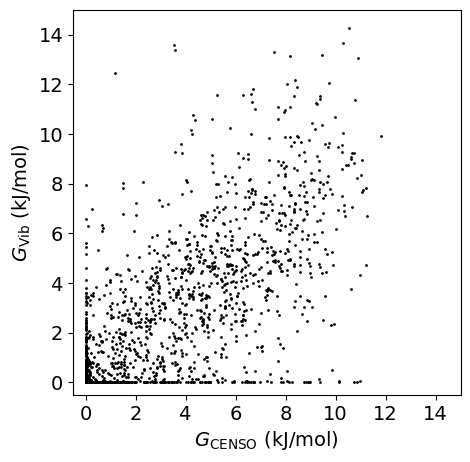

In [40]:
censo_eng_list = compare_df['CENSO Energy [kJ/mol]'].values
vibcalc_eng_list = compare_df['VibCalc Energy [kJ/mol]'].values


fig, ax = plt.subplots(1,1,figsize=(5,5),sharey= False)
ax.plot(censo_eng_list,vibcalc_eng_list,'ko',markersize=1)
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
ax.set_xlabel('$G_\mathrm{CENSO}$ (kJ/mol)',fontsize=14)
ax.set_ylabel('$G_\mathrm{Vib}$ (kJ/mol)',fontsize=14)
ax.set_xticks([0,2,4,6,8,10,12,14])
ax.set_xlim(-0.5,15)
ax.set_yticks([0,2,4,6,8,10,12,14])
ax.set_ylim(-0.5,15)
            
plt.savefig('/Users/z5380625/Documents/Research/2_BigData/Plots/VibFreqGFE_CENSOGFE_Scatter.pdf',bbox_inches='tight')
plt.show()

## Plot Difference GFE vs Geom RMSD

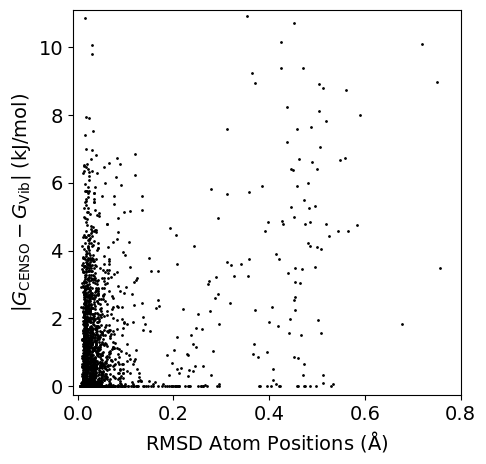

In [55]:
diff_eng_list = np.abs(compare_df['CENSO-VibCalc Energy [kJ/mol]'].values)
RMSD_list = compare_df['Geometry RMSD'].values

fig, ax = plt.subplots(1,1,figsize=(5,5),sharey= False)
ax.plot(RMSD_list,diff_eng_list,'ko',markersize=1)
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
ax.set_xlabel(r'RMSD Atom Positions ($\mathrm{\AA}$)',fontsize=14)
ax.set_ylabel(r'$|G_\mathrm{CENSO}-G_\mathrm{Vib}|$ (kJ/mol)',fontsize=14)
# ax.set_xticks([0,2,4,6,8,10,12,14])
ax.set_xlim(-0.01,.8)
#ax.set_yticks([0,2,4,6,8,10,12,14])
ax.set_ylim(-0.25,11.1)

plt.savefig('/Users/z5380625/Documents/Research/2_BigData/Plots/Abs_DiffGFE_GeomRMSD_Scatter.pdf',bbox_inches='tight')
plt.show()

### 5.1.2.2 Plotting Average Gibbs Energy Difference per Molecule Size 

#### Method 1: Violin Plot

In [22]:
def set_axis_style(ax, labels):
    ax.xaxis.set_tick_params(direction='out')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks(np.arange(1, len(labels) + 1), labels=labels)
    ax.set_xlim(0.25, len(labels) + 0.75)
    ax.set_xlabel('Number of Atoms',fontsize=12)
    ax.set_ylabel(r'$G_\mathrm{CENSO}-G_\mathrm{Vib}$ (kJ/mol)',fontsize=12)
    
def set_violin_style(parts):
    for pc in parts['bodies']:
        pc.set_facecolor('#648FFF')
        pc.set_edgecolor('k')
        pc.set_alpha(1)
        pc.set_linewidth(0.5)
    parts['cbars'].set_color('k')
    parts['cbars'].set_linewidths(0.5)
    parts['cmaxes'].set_color('k')
    parts['cmaxes'].set_linewidths(0.5)
    parts['cmins'].set_color('k')
    parts['cmins'].set_linewidths(0.5)
    


Average Over all Molecules in 5_Atoms:  0.3070388234016718
Average Over all Molecules in 6_Atoms:  0.3348004888317038
Average Over all Molecules in 7_Atoms:  0.5281794046491473
Average Over all Molecules in 8_Atoms:  0.8634036235279117
Average Over all Molecules in 9_Atoms:  0.9047129069031133
Average Over all Molecules in 10_Atoms:  0.9315886879745365
Average Over all Molecules in 11_Atoms:  0.9900917296168411
Average Over all Molecules:  0.8998757525910995


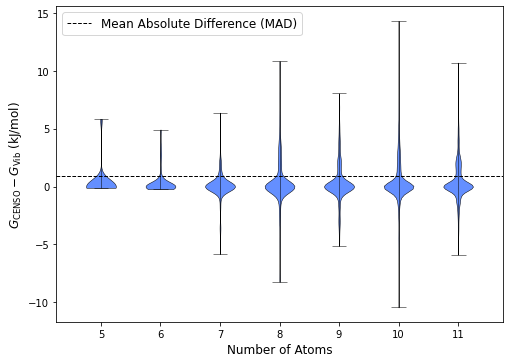

In [23]:
## Print Average Gibbs Energy Difference per Molecule Size ##

diff_per_size_list = []
for num_atoms in np.arange(5,12,1):
    loc_num_atoms = str(num_atoms)+'_Atoms'
    num_atoms_df = compare_df.loc[compare_df['# Atoms'] == num_atoms]
    print('Average Over all Molecules in '+loc_num_atoms+': ',np.average(np.abs(num_atoms_df['CENSO-VibCalc Energy [kJ/mol]'].values)))
    diff_per_size_list.append(np.average(num_atoms_df['CENSO-VibCalc Energy [kJ/mol]'].values))

## Total Average Gibbs Energy Difference ##
print('Average Over all Molecules: ',np.average(np.abs(compare_df['CENSO-VibCalc Energy [kJ/mol]'].values)))

## Plot Gibbs Energy Difference per Molecule Size as Violinplot ##
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
diff_per_mol_size_list = []
for num_atoms in np.arange(5,12,1):
    num_atoms_df = compare_df.loc[compare_df['# Atoms'] == num_atoms]
    diff_per_mol_size_list.append(np.asarray((num_atoms_df['CENSO-VibCalc Energy [kJ/mol]'].values)))
parts = ax.violinplot(diff_per_mol_size_list, showmeans=False, showmedians=False, showextrema=True)

# set style for the axes
labels = np.arange(5,12,1)
set_axis_style(ax, labels)
set_violin_style(parts)
ax.axhline(np.average(np.abs(compare_df['CENSO-VibCalc Energy [kJ/mol]'].values)),linestyle='--',color='k',linewidth=1)
plt.subplots_adjust(bottom=0.15, wspace=0.05)

#custom legend
custom_lines = [Line2D([0], [0],color='k', lw=1,linestyle='--')]
ax.legend(custom_lines, ['Mean Absolute Difference (MAD)'], loc = 'upper left',fontsize=12)

plt.savefig(comp_loc+'1_BigData/Data Analysis/compare_gibbs_per_mol_size_violin.png')

plt.show()


#### Method 2 (Unfinished, Needs thought on how to handles zeroes): Histogram/KDE

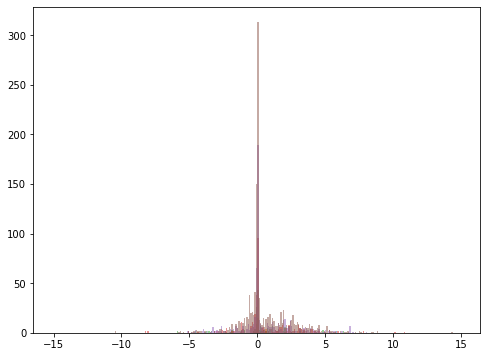

In [24]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))

bins = np.arange(-15,15,0.1)
for num_atoms in range(5,11,1):
    num_atoms_df = compare_df.loc[compare_df['# Atoms'] == num_atoms]
    diff_per_mol_size = np.asarray((num_atoms_df['CENSO-VibCalc Energy [kJ/mol]'].values))
    diff_per_mol_size_NOzeroes = [value for value in diff_per_mol_size if value != 0]
    ax.hist(diff_per_mol_size_NOzeroes, density=False, bins=bins, alpha=0.5)
    kde = stats.gaussian_kde(diff_per_mol_size_NOzeroes)
    
    xx = np.linspace(-15,15,len(bins))
    #ax.plot(xx, kde(xx))
    
plt.show()

### 5.1.2.3 Plotting Compare Gibbs: MAD,RMSE,MedianAD per mol_size 

In [142]:
def set_axis_style(ax):
    ax.xaxis.set_tick_params(direction='out')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xlabel('Number of Atoms',fontsize=12)
    ax.set_ylabel(r'MedianAD $G_\mathrm{CENSO}-G_\mathrm{Vib}$ (kJ/mol)',fontsize=12)

def MAD(data):
    return np.average(np.abs(data))

def RMSE(data):
    return np.sqrt(np.sum(data**2)/len(data))

def MedianAD(data):
    return np.median(np.abs(data))

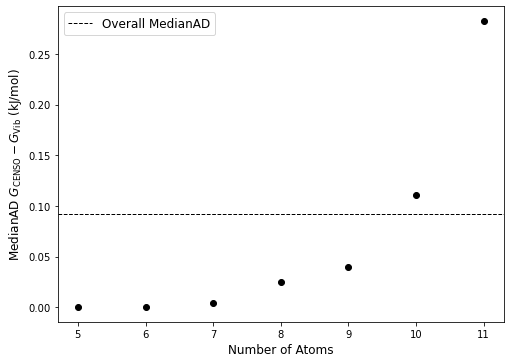

In [143]:
## Compute Average Gibbs Energy Difference per Molecule Size ##

diff_mol_size_list = []
atoms_num_list = np.arange(5,12,1)
for num_atoms in atoms_num_list:
    loc_num_atoms = str(num_atoms)+'_Atoms'
    num_atoms_df = compare_df.loc[compare_df['# Atoms'] == num_atoms]
    diff_mol_size_list.append(MedianAD(num_atoms_df['CENSO-VibCalc Energy [kJ/mol]'].values))

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))


ax.plot(diff_mol_size_list,'ko')
set_axis_style(ax)
ax.set_xticks(np.arange(0,len(atoms_num_list)),atoms_num_list)
ax.axhline(MedianAD(compare_df['CENSO-VibCalc Energy [kJ/mol]'].values),linestyle='--',color='k',linewidth=1)
plt.subplots_adjust(bottom=0.15, wspace=0.05)

#custom legend
custom_lines = [Line2D([0], [0],color='k', lw=1,linestyle='--')]

ax.legend(custom_lines, ['Overall MedianAD'], loc = 'upper left',fontsize=12)

plt.savefig(comp_loc+'1_BigData/Data Analysis/compare_gibbs_per_mol_size_MedianAD.png')

plt.show()

### 5.1.2.4 Plotting Compare Gibbs: Average per molecule with X # of atoms

Average Over all Molecules in 2_Atoms:  0.0
Average Over all Molecules in 3_Atoms:  0.0
Average Over all Molecules in 4_Atoms:  0.0
Average Over all Molecules in 5_Atoms:  0.3014990233321441
Average Over all Molecules in 6_Atoms:  0.31869578530203624
Average Over all Molecules in 7_Atoms:  0.10588893627975998
Average Over all Molecules in 8_Atoms:  0.38038665385263015
Average Over all Molecules in 9_Atoms:  0.35855273743844057
Average Over all Molecules in 10_Atoms:  0.4583157941018036
Average Over all Molecules:  0.39889131796407273


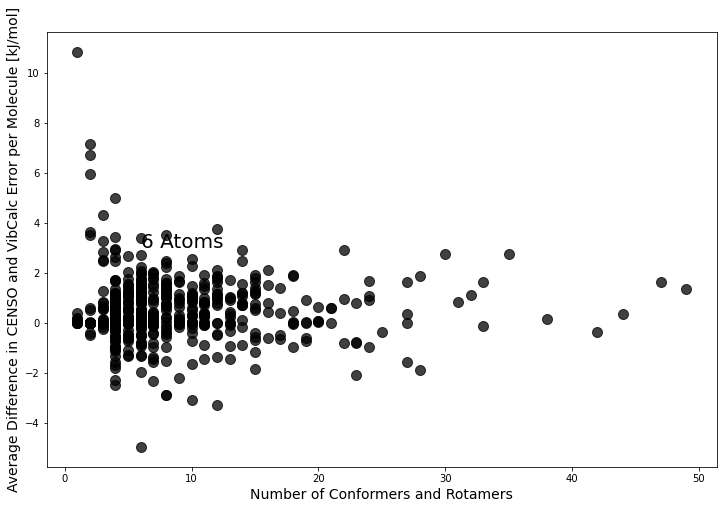

In [27]:
for num_atoms in np.arange(2,11,1):
    loc_num_atoms = str(num_atoms)+'_Atoms'
    num_atoms_df = compare_df.loc[compare_df['# Atoms'] == num_atoms]
    print('Average Over all Molecules in '+loc_num_atoms+': ',np.average(num_atoms_df['CENSO-VibCalc Energy [kJ/mol]'].values))
    

print('Average Over all Molecules: ',np.average(compare_df['CENSO-VibCalc Energy [kJ/mol]'].values))

unique_mol = np.unique(compare_df['Formula'].values)
avg_per_mol_list = []
num_list = []
for mol in unique_mol:
    energy_diff = compare_df.loc[compare_df['Formula'] == mol]['CENSO-VibCalc Energy [kJ/mol]'].values
    num_conf_rota = len(energy_diff)
    avg_per_mol_list.append(np.average(energy_diff))
    num_list.append(num_conf_rota)

plt.figure(figsize=(12, 8))
plt.plot(num_list,avg_per_mol_list,'ko',markersize=10,alpha=0.75)
plt.xlabel('Number of Conformers and Rotamers',fontsize=14)
plt.ylabel('Average Difference in CENSO and VibCalc Error per Molecule [kJ/mol]',fontsize=14)
plt.text(6,3,'6 Atoms', fontsize=20)
plt.savefig(comp_loc+'1_BigData/Data Analysis/compare_gibbs_'+loc_num_atoms.split('/')[0]+'.png')


In [28]:
energy_diff = compare_df['CENSO-VibCalc Energy [kJ/mol]'].values
RMSD = compare_df['Geometry RMSD'].values
print('Absolute Mean, RMSD: ',np.average(abs(RMSD)))
copy_df = compare_df.copy()
filter_df = copy_df.loc[copy_df['Geometry RMSD'] > 0.5]

print('C2H5OP_3_ROTA_1')
print(compare_df.loc[compare_df['Formula'] == 'C2H5OP_3'].loc[compare_df['CONF#/ROTA#'] == 'ROTA1']['Geometry RMSD'].values[0])
print(compare_df.loc[compare_df['Formula'] == 'C2H5OP_3'].loc[compare_df['CONF#/ROTA#'] == 'ROTA1']['CENSO-VibCalc Energy [kJ/mol]'].values[0],'\n')
print('C2H4N4_6_CONF1')
print(compare_df.loc[compare_df['Formula'] == 'C2H4N4_6'].loc[compare_df['CONF#/ROTA#'] == 'CONF1']['Geometry RMSD'].values[0])
print(compare_df.loc[compare_df['Formula'] == 'C2H4N4_6'].loc[compare_df['CONF#/ROTA#'] == 'CONF1']['CENSO-VibCalc Energy [kJ/mol]'].values[0],'\n')
print('CH6NO2P_1_ROTA9')
print(compare_df.loc[compare_df['Formula'] == 'CH6NO2P_1'].loc[compare_df['CONF#/ROTA#'] == 'ROTA9']['Geometry RMSD'].values[0])
print(compare_df.loc[compare_df['Formula'] == 'CH6NO2P_1'].loc[compare_df['CONF#/ROTA#'] == 'ROTA9']['CENSO-VibCalc Energy [kJ/mol]'].values[0],'\n')
print('C2H4S2_4_ROTA4')
print(compare_df.loc[compare_df['Formula'] == 'C2H4S2_4'].loc[compare_df['CONF#/ROTA#'] == 'ROTA4']['Geometry RMSD'].values[0])
print(compare_df.loc[compare_df['Formula'] == 'C2H4S2_4'].loc[compare_df['CONF#/ROTA#'] == 'ROTA4']['CENSO-VibCalc Energy [kJ/mol]'].values[0],'\n')

print(len(filter_df))
filter_df

Absolute Mean, RMSD:  0.04620310976769476
C2H5OP_3_ROTA_1
0.011326666626559755
0.0 

C2H4N4_6_CONF1
0.5290930882490851
14.332329154247418 

CH6NO2P_1_ROTA9
0.0259423619110656
5.936775299720466 

C2H4S2_4_ROTA4
0.5108154639152921
0.8335955054499209 

38


,Formula,# Atoms,CONF#/ROTA#,CENSO Energy [kJ/mol],VibCalc Energy [kJ/mol],CENSO-VibCalc Energy [kJ/mol],Geometry RMSD
227,C2H2O4,8,CONF1,1.832597,0.000000,1.832597,0.674753
303,C2H4S2_4,8,CONF2,1.253675,0.420080,0.833596,0.510815
344,C3H3NO_1,8,CONF2,4.104966,0.005251,4.099715,0.508512
468,CH5OP_1,8,CONF3,7.818207,0.000000,7.818207,0.516775
545,C2H2O4,8,ROTA1,1.832597,0.000000,1.832597,0.674524
657,C2H4S2_4,8,ROTA4,1.253675,0.420080,0.833596,0.510815
710,C3H3NO_1,8,ROTA5,5.816002,0.018378,5.797624,0.522006
713,C3H3NO_1,8,ROTA4,4.104966,0.002625,4.102340,0.508435
930,CH5OP_1,8,ROTA10,7.818207,0.000000,7.818207,0.516776
1085,C2H5NO_5,9,CONF3,8.120139,0.073514,8.046625,0.504084


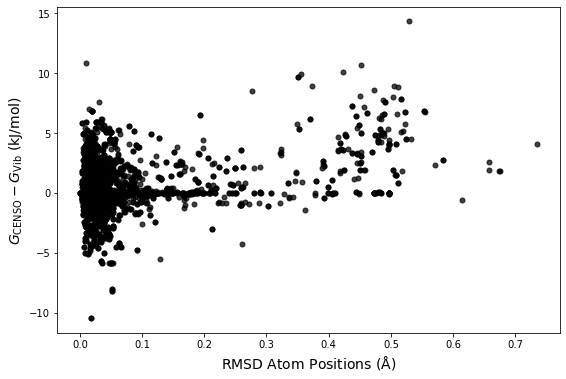

In [29]:
plt.figure(figsize=(9, 6))
plt.plot(RMSD,energy_diff,'ko',markersize=5,alpha=0.75)
plt.xlabel(r'RMSD Atom Positions ($\mathrm{\AA}$)',fontsize=14)
plt.ylabel(r'$G_\mathrm{CENSO}-G_\mathrm{Vib}$ (kJ/mol)',fontsize=14)

plt.savefig(comp_loc+'1_BigData/Data Analysis/compare_gibbs_GeomRMSD.png')

plt.show()

### 5.1.2.6 Plot: RMSD vs Molecular Size

In [30]:
def set_axis_style(ax, labels):
    ax.xaxis.set_tick_params(direction='out')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks(np.arange(1, len(labels) + 1), labels=labels)
    ax.set_xlim(0.25, len(labels) + 0.75)
    ax.set_xlabel('# Atoms',fontsize=12)
    ax.set_ylabel(r'RMSD Atom Positions ($\mathrm{\AA}$)',fontsize=12)
    

0.04620310976769476


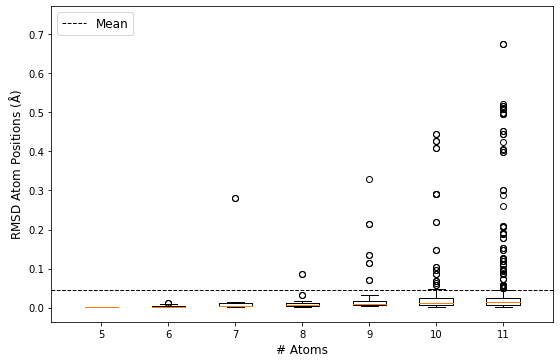

In [31]:
## Plot RMSD per Molecule Size as swarm plot ##
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9, 6))

RMSD_per_size_list = []
for num_atoms in np.arange(2,12,1):
    num_atoms_df = compare_df.loc[compare_df['# Atoms'] == num_atoms]
    RMSD_per_size_list.append(num_atoms_df['Geometry RMSD'].values)


parts = ax.boxplot(RMSD_per_size_list)#, showmeans=False, showmedians=False, showextrema=True)


# set style for the axes
labels = np.arange(5,12,1)
set_axis_style(ax, labels)
#set_violin_style(parts)
ax.axhline(np.average(np.abs(compare_df['Geometry RMSD'].values)),linestyle='--',color='k',linewidth=1)
plt.subplots_adjust(bottom=0.15, wspace=0.05)

#custom legend
custom_lines = [Line2D([0], [0],color='k', lw=1,linestyle='--')]
ax.legend(custom_lines, ['Mean Absolute Difference (MAD)'], loc = 'upper left',fontsize=12)


#custom legend
custom_lines = [Line2D([0], [0],color='k', lw=1,linestyle='--')]
ax.legend(custom_lines, ['Mean'], loc = 'upper left',fontsize=12)

print(np.average(compare_df['Geometry RMSD'].values))

#plt.savefig(comp_loc+'1_BigData/Data Analysis/compare_RMSD_per_mol_size_violin.png')

plt.show()

1121


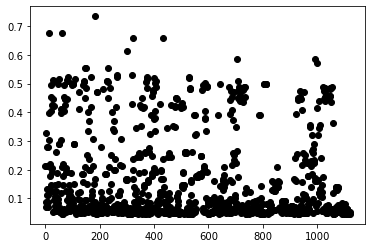

In [32]:
plt.plot(compare_df.loc[compare_df['Geometry RMSD'] > np.average(compare_df['Geometry RMSD'].values)]['Geometry RMSD'].values,'ko')
print(len(compare_df.loc[compare_df['Geometry RMSD'] > np.average(compare_df['Geometry RMSD'].values)]['Geometry RMSD'].values))
#plt.show()

### 5.1.2.7 Histogram RMSD Total

In [62]:
def set_axis_style(ax):
    ax.xaxis.set_tick_params(direction='out')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xlabel(r'RMSD Atom Positions ($\mathrm{\AA}$)',fontsize=12)
    ax.set_ylabel(r'Molecule Count',fontsize=12)

0.255434828994737


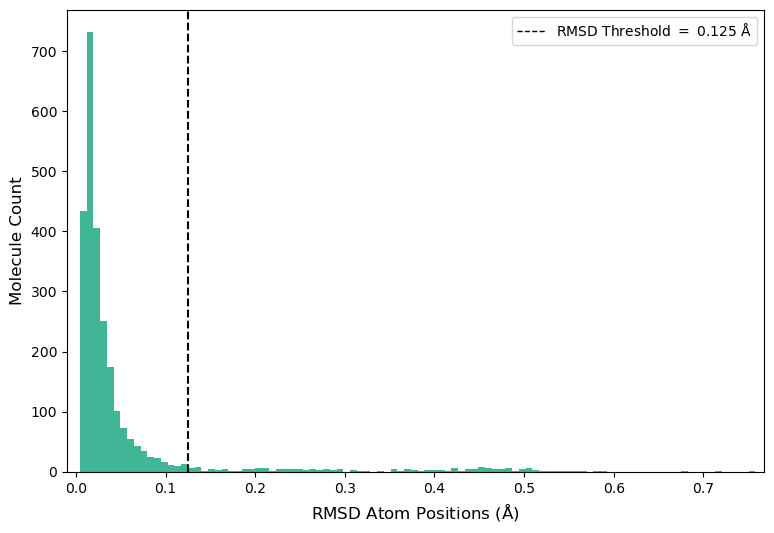

In [63]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9, 6))
set_axis_style(ax)
n, bins, patches = ax.hist(compare_df['Geometry RMSD'].values, bins=100, density=False, facecolor='#009E73', alpha=0.75)
ax.set_xlim(-0.01,np.max(compare_df['Geometry RMSD'].values+0.01))

percentile_95 = np.percentile(compare_df['Geometry RMSD'].values,95)
ax.axvline(0.125,color='k',linestyle='--')

custom_line = [Line2D([0], [0], color='k', lw=1, linestyle='--')]
#ax.legend(custom_line, [r'$95^{\mathrm{th}}$ Percentile'])
ax.legend(custom_line, [r'RMSD Threshold $=$ 0.125 $\mathrm{\AA}$'])
print(percentile_95)
plt.savefig(comp_loc+'2_BigData/Plots/compare_RMSD_ALLmols_percentile.pdf')
plt.show()

### 5.1.2.8 Histogram RMSD per mol_size

In [35]:
def set_axis_style(ax):
    ax.xaxis.set_tick_params(direction='out')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xlabel(r'RMSD Atom Positions ($\mathrm{\AA}$)',fontsize=12)
    ax.set_ylabel(r'Molecules',fontsize=12)
    return

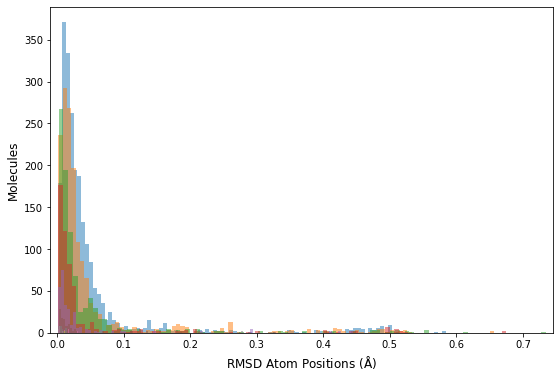

In [36]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9, 6))
set_axis_style(ax)

num_outliers_list = []
percentiles_list = []
outlier_list = []
for num_atoms in np.arange(11,1,-1):
    num_atoms_df = compare_df.loc[compare_df['# Atoms'] == num_atoms]
    ax.hist(num_atoms_df['Geometry RMSD'].values, bins=100, density=False, alpha=0.5)
    ax.set_xlim(-0.01,np.max(compare_df['Geometry RMSD'].values+0.01))
    percentile_95 = np.percentile(num_atoms_df['Geometry RMSD'].values,95)
    percentiles_list.append(percentile_95)
    num_outliers_list.append(len(num_atoms_df.loc[num_atoms_df['Geometry RMSD'] > percentile_95]['Geometry RMSD'].values)*100/len(num_atoms_df['Geometry RMSD'].values))
    outlier_list.append(len(num_atoms_df.loc[num_atoms_df['Geometry RMSD'] > percentile_95]['Geometry RMSD'].values))

plt.savefig(comp_loc+'1_BigData/Data Analysis/compare_RMSD_SEPmols.png')
plt.show()


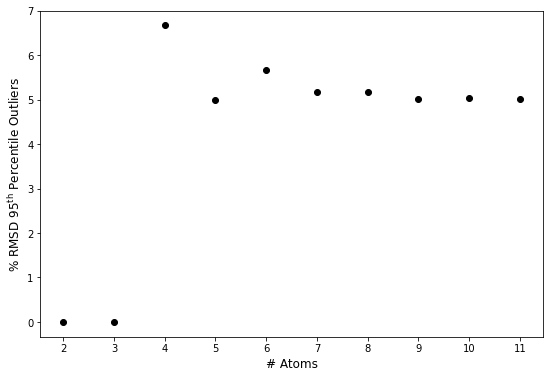

In [37]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9, 6))
ax.plot(np.arange(11,1,-1),num_outliers_list,'ko')
ax.set_xlabel('# Atoms',fontsize=12)
ax.set_ylabel(r'% RMSD $95^{\mathrm{th}}$ Percentile Outliers',fontsize=12)
ax.xaxis.set_tick_params(direction='out')
ax.xaxis.set_ticks_position('bottom')
ax.set_xticks(np.arange(11,1,-1))

plt.savefig(comp_loc+'1_BigData/Data Analysis/compare_numatoms_RMSDPercentile.png')

plt.show()

### 5.1.2.9 Add Flag to Overall Dataframe

In [38]:
df_mols = df['Formula'].values
total_rmsd_list = []
for ind, values in df.iterrows():
    rmsd = compare_df.loc[(compare_df['Formula'] == values[0]) & (compare_df['CONF#/ROTA#'] == values[3])]['Geometry RMSD'].values[0]
    total_rmsd_list.append(rmsd)
print(len(total_rmsd_list))
df['Geometry RMSD'] = total_rmsd_list

5679


In [39]:
flag_list = []
percentiles_list = np.flip(percentiles_list)
print(percentiles_list)
for ind, values in df.iterrows():
    num_atoms = values[2]
    if values[-1] <= percentiles_list[int(num_atoms)-2]:
        flag_list.append('Y')
    elif values[-1] > percentiles_list[int(num_atoms)-2]:
        flag_list.append('N')

df['Geometry Flag'] = flag_list
    

[0.0023768  0.01131896 0.16056176 0.03393292 0.11358016 0.12503122
 0.28759951 0.19839123 0.24939887 0.16390722]


In [40]:
df

,Formula,SMILES,# Atoms,Conf#/Rota#,Relative Energy [kJ/mol],RawFreq [cm-1],ScaledFreq [cm-1],Intensity,mu_a [D],mu_b [D],mu_c [D],mu_tot [D],mu_amu_bmu_c,A [cm-1],B [cm-1],C [cm-1],Geometry RMSD,Geometry Flag
0,C2H2,C#C,4,CONF1,0.000000,"[688.4955, 688.4955, 775.8896, 775.8896, 2092....","[667.2898385999999, 667.2898385999999, 751.992...","[0.0, 0.0, 101.0567, 101.0567, 0.0, 90.6391, 0.0]",2.000915e-07,2.119624e-07,0.000003,0.000003,1.109623e-19,0.000000,1.193039,1.193039,0.001305,Y
1,C2H2O2,O=CC=O,6,CONF1,0.000000,"[128.2724, 341.7855, 558.5713, 818.55, 1080.10...","[124.32161008, 331.2585066, 541.36730396, 793....","[35.1568, 53.4123, 0.0, 2.0934, 0.0, 0.0, 8.29...",-9.995060e-08,-1.000049e-07,-0.000010,0.000010,-9.695684e-20,1.870834,0.160806,0.148078,0.006117,Y
2,C2H2OS_1,C#CSO,6,CONF1,0.000000,"[176.974, 324.5001, 437.1243, 462.7268, 566.46...","[171.52320079999998, 314.50549692, 423.6608715...","[1.9957, 42.321, 59.2577, 24.9507, 61.913, 10....",5.581037e-01,6.441872e-01,-1.376839,1.619303,-4.950055e-01,0.675594,0.133525,0.112625,0.007609,Y
3,C2H2OS_2,O=CC=S,6,CONF1,0.000000,"[107.5151, 296.6725, 494.7942, 811.0193, 1042....","[104.20363492, 287.534987, 479.55453864, 786.0...","[17.3018, 18.5149, 6.0628, 19.0213, 3.3058, 51...",-1.104956e+00,-9.335503e-02,-0.000004,1.108893,-3.847521e-07,1.732895,0.096180,0.091123,0.011577,Y
4,C2H2O_1,C1=CO1,5,CONF1,0.000000,"[229.2692, 565.9187, 705.9046, 909.7995, 990.1...","[222.20770864, 548.4884040399999, 684.16273831...","[2.9425, 88.5051, 0.0, 63.1626, 6.8996, 17.822...",2.372292e+00,-1.543807e-03,-0.000220,2.372293,8.074442e-07,1.128473,0.899832,0.500633,0.004052,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5674,H5N2OPS,NP(N)(O)=S,10,ROTA16,0.092943,"[226.7113, 236.2019, 260.8023, 343.9865, 354.8...","[219.72859196, 228.92688148, 252.7695891599999...","[14.0529, 13.1778, 25.14, 3.4153, 63.3309, 48....",-2.929984e+00,-1.876646e-01,0.190036,2.942132,1.044919e-01,0.144513,0.087829,0.083185,0.021574,Y
5675,H5N2OPS,NP(N)(O)=S,10,ROTA10,0.143090,"[226.6095, 235.4049, 259.1879, 343.8866, 354.4...","[219.62992739999999, 228.15442908, 251.2049126...","[13.4902, 14.0157, 25.0132, 3.6689, 61.3996, 5...",-2.912476e+00,-4.013332e-01,0.105494,2.941890,1.233089e-01,0.144515,0.087824,0.083186,0.021341,Y
5676,H5N2OPS,NP(N)(O)=S,10,ROTA8,0.040433,"[226.587, 235.1242, 258.5889, 344.027, 353.300...","[219.6081204, 227.88237464, 250.62436188, 333....","[12.7281, 14.7424, 25.8892, 3.0567, 61.0737, 4...",-2.889070e+00,-4.537009e-01,0.315106,2.941405,4.130331e-01,0.144515,0.087830,0.083189,0.018614,Y
5677,H5N2OPS,NP(N)(O)=S,10,ROTA12,0.088217,"[226.7157, 236.1983, 260.7997, 343.9862, 354.8...","[219.73285643999998, 228.92339235999998, 252.7...","[14.0513, 13.1749, 25.137, 3.4132, 63.333, 48....",-2.930070e+00,-1.867935e-01,0.189701,2.942140,1.038268e-01,0.144513,0.087829,0.083185,0.021683,Y


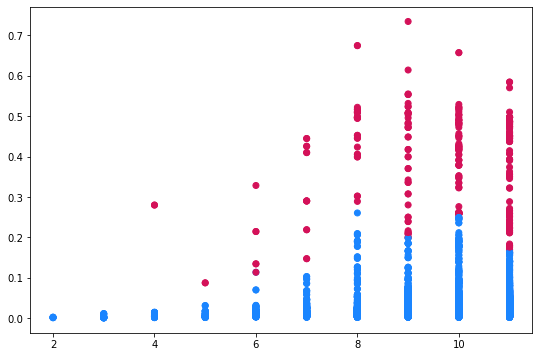

In [41]:
## Just testing fo fun, plot isn't interesting. More is shown in above plots ##

RMSD = df['Geometry RMSD'].values
num_atoms = df['# Atoms'].values
geom_flags = df['Geometry Flag']
colours = {'Y':'#1A85FF', 'N':'#D41159'}

plt.figure(figsize=(9, 6))
plt.scatter(num_atoms,RMSD,c=geom_flags.map(colours))
#plt.xlabel(r'RMSD Atom Positions ($\mathrm{\AA}$)',fontsize=14)
#plt.ylabel(r'$G_\mathrm{CENSO}-G_\mathrm{Vib}$ (kJ/mol)',fontsize=14)

#plt.savefig(comp_loc+'1_BigData/Data Analysis/compare_gibbs_GeomRMSD.png')

plt.show()

## 5.1.3 Compare Rot Consts to RMSD

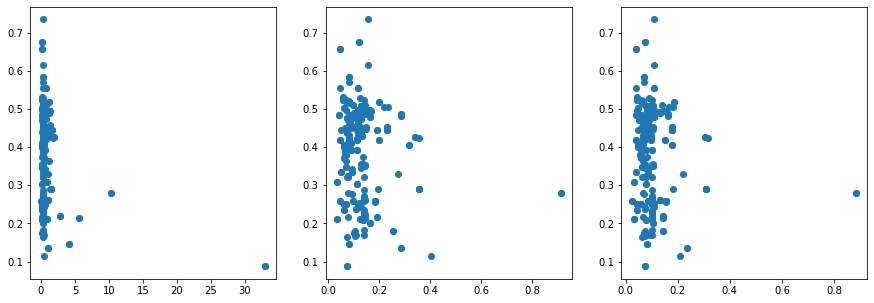

In [42]:
## No real relationship ##

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

A = df.loc[df['Geometry Flag'] == 'N']['A [cm-1]'].values
B = df.loc[df['Geometry Flag'] == 'N']['B [cm-1]'].values
C = df.loc[df['Geometry Flag'] == 'N']['C [cm-1]'].values

RMSD = df.loc[df['Geometry Flag'] == 'N']['Geometry RMSD'].values

ax[0].scatter(A,RMSD)
ax[1].scatter(B,RMSD)
ax[2].scatter(C,RMSD)

## 5.1.4 Compare Dipole Moments and Rot Consts

### 5.1.4.1 All Mol Sizes

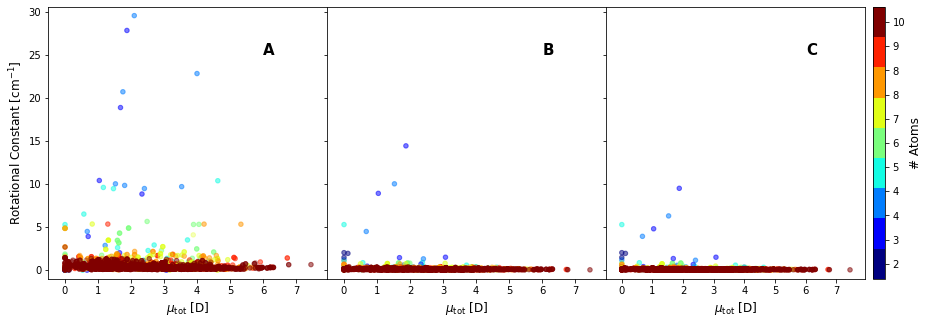

In [43]:
#.loc[df['Geometry Flag'] == 'N']

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 5),sharey=True,sharex=True)

#geom_flags = df['Geometry Flag']
#colours = {'Y':'#1A85FF', 'N':'#D41159'}

num_atoms = df.loc[df['Geometry Flag'] == 'Y']['# Atoms'].values
cmap = cm.get_cmap(plt.cm.jet, 11)
norm = cm.colors.BoundaryNorm(np.arange(2,12,1), cmap.N)
bounds = np.linspace(2.5,10.5,11)

A = df.loc[df['Geometry Flag'] == 'Y']['A [cm-1]'].values
B = df.loc[df['Geometry Flag'] == 'Y']['B [cm-1]'].values
C = df.loc[df['Geometry Flag'] == 'Y']['C [cm-1]'].values

Tot_DipMom = df.loc[df['Geometry Flag'] == 'Y']['mu_tot [D]'].values

axs[0].scatter(Tot_DipMom,A,c=num_atoms,cmap=cmap,norm=norm,alpha=0.3,s=20)
axs[1].scatter(Tot_DipMom,B,c=num_atoms,cmap=cmap,norm=norm,alpha=0.3,s=20)
axs[2].scatter(Tot_DipMom,C,c=num_atoms,cmap=cmap,norm=norm,alpha=0.3,s=20)

divider = make_axes_locatable(axs[2])
cax = divider.append_axes("right", size="5%", pad=0.1)
cb = mpl.colorbar.ColorbarBase(cax,cmap=cmap, norm=norm,
    spacing='uniform', ticks=bounds, boundaries=bounds, format='%1i')
cb.set_label('# Atoms',fontsize=12)
for ax in axs:
    ax.set_xlabel(r'$\mu_\mathrm{tot}$ [D]',fontsize=12)
    ax.set_xlim(-0.5,np.max(Tot_DipMom)+0.5)
    ax.set_ylim(-1,np.max(A)+1)
axs[0].set_ylabel(r'Rotational Constant [cm$^{-1}$]',fontsize=12)

axs[0].text(6,25,'A',fontsize=15,weight='bold')
axs[1].text(6,25,'B',fontsize=15,weight='bold')
axs[2].text(6,25,'C',fontsize=15,weight='bold')




plt.subplots_adjust(wspace=0.0)

### 5.1.4.2 Select Mol Sizes

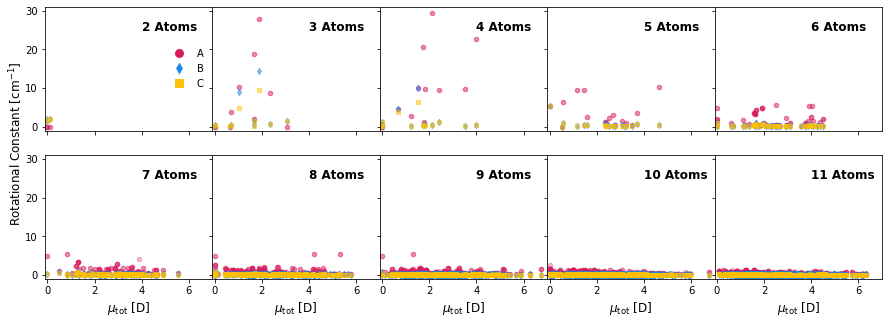

In [104]:
#.loc[df['Geometry Flag'] == 'N']

fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(15, 5),sharey=True,sharex=True)
#geom_flags = df['Geometry Flag']
#colours = {'Y':'#1A85FF', 'N':'#D41159'}
i=0
j=0
for num_atoms in np.arange(2,12,1):
    if i == 5:
        i=0
        j+=1
    if j==2:
        break
    num_atom_df = df.loc[df['# Atoms'] == num_atoms]
    num_atoms = num_atom_df.loc[num_atom_df['Geometry Flag'] == 'Y']['# Atoms'].values
    cmap = cm.get_cmap(plt.cm.jet, 11)
    norm = cm.colors.BoundaryNorm(np.arange(2,12,1), cmap.N)
    bounds = np.linspace(2.5,10.5,11)

    A = num_atom_df.loc[num_atom_df['Geometry Flag'] == 'Y']['A [cm-1]'].values
    B = num_atom_df.loc[num_atom_df['Geometry Flag'] == 'Y']['B [cm-1]'].values
    C = num_atom_df.loc[num_atom_df['Geometry Flag'] == 'Y']['C [cm-1]'].values

    Tot_DipMom = num_atom_df.loc[num_atom_df['Geometry Flag'] == 'Y']['mu_tot [D]'].values

    axs[j,i].scatter(Tot_DipMom,A,alpha=0.3,s=20,c='#D81B60',marker='o',)
    axs[j,i].scatter(Tot_DipMom,B,alpha=0.3,s=20,c='#1E88E5',marker='d')
    axs[j,i].scatter(Tot_DipMom,C,alpha=0.3,s=20,c='#FFC107',marker='s')
    
    axs[j,i].text(4,25,str(num_atoms[0])+' Atoms',fontsize=12,weight='bold')
    
    if j==1:
        axs[1,i].set_xlabel(r'$\mu_\mathrm{tot}$ [D]',fontsize=12)
    i+=1
    
axs[0,0].set_xlim(-.1,7)
axs[0,0].set_ylim(-1,31)    
fig.text(0.09, 0.5, r'Rotational Constant [cm$^{-1}$]', va='center', rotation='vertical',fontsize=12)

legend_elements = [Line2D([0], [0], marker='o',markerfacecolor='#D81B60', markersize=10, color='w', label='A'),
                  Line2D([0], [0], marker='d',markerfacecolor='#1E88E5', markersize=10, color='w', label='B'),
                  Line2D([0], [0], marker='s',markerfacecolor='#FFC107', markersize=10, color='w', label='C')]
leg = axs[0,0].legend(handles=legend_elements,loc='center right',frameon=True)
leg.get_frame().set_edgecolor('k')
leg.get_frame().set_linewidth(0.0)

plt.subplots_adjust(wspace=0.0)

plt.savefig(comp_loc+'1_BigData/Data Analysis/compare_DipMom_RotConst_ALL.png')

plt.show()

### 5.1.4.3 A

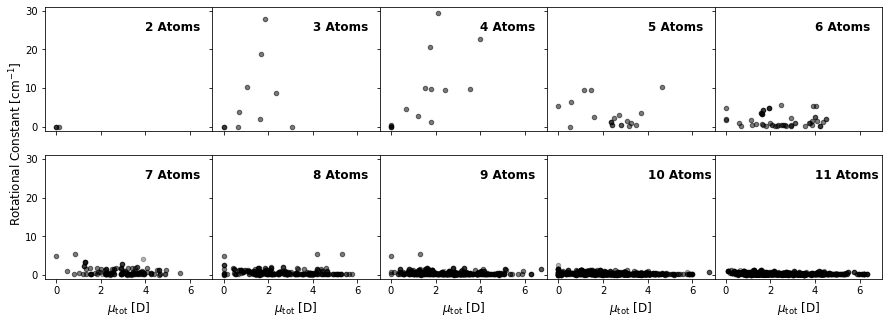

In [123]:
#.loc[df['Geometry Flag'] == 'N']

fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(15, 5),sharey=True,sharex=True)
#geom_flags = df['Geometry Flag']
#colours = {'Y':'#1A85FF', 'N':'#D41159'}
i=0
j=0
for num_atoms in np.arange(2,12,1):
    if i == 5:
        i=0
        j+=1
    if j==2:
        break
    num_atom_df = df.loc[df['# Atoms'] == num_atoms]
    num_atoms = num_atom_df.loc[num_atom_df['Geometry Flag'] == 'Y']['# Atoms'].values
    cmap = cm.get_cmap(plt.cm.jet, 11)
    norm = cm.colors.BoundaryNorm(np.arange(2,12,1), cmap.N)
    bounds = np.linspace(2.5,10.5,11)

    A = num_atom_df.loc[num_atom_df['Geometry Flag'] == 'Y']['A [cm-1]'].values

    Tot_DipMom = num_atom_df.loc[num_atom_df['Geometry Flag'] == 'Y']['mu_tot [D]'].values

    axs[j,i].scatter(Tot_DipMom,A,alpha=0.3,s=20,c='k',marker='o')
    
    axs[j,i].text(4,25,str(num_atoms[0])+' Atoms',fontsize=12,weight='bold')
    
    if j==1:
        axs[1,i].set_xlabel(r'$\mu_\mathrm{tot}$ [D]',fontsize=12)
    i+=1
    
axs[0,0].set_xlim(-0.5,7)
axs[0,0].set_ylim(-1,31)    
fig.text(0.09, 0.5, r'Rotational Constant [cm$^{-1}$]', va='center', rotation='vertical',fontsize=12)

plt.subplots_adjust(wspace=0.0)

plt.savefig(comp_loc+'1_BigData/Data Analysis/compare_DipMom_RotConstA.png')

plt.show()

### 5.1.4.4 B

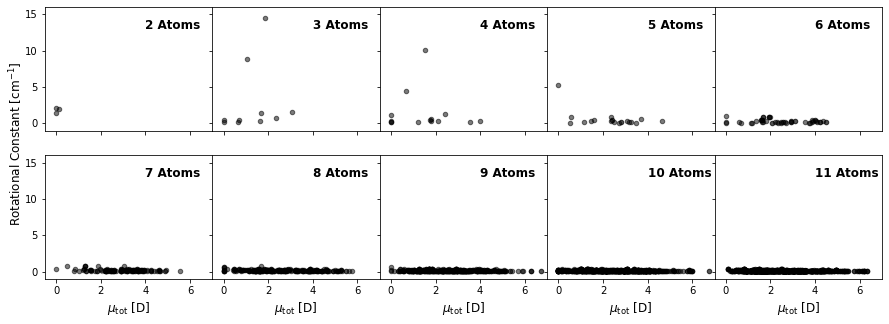

In [124]:
#.loc[df['Geometry Flag'] == 'N']

fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(15, 5),sharey=True,sharex=True)
#geom_flags = df['Geometry Flag']
#colours = {'Y':'#1A85FF', 'N':'#D41159'}
i=0
j=0
for num_atoms in np.arange(2,12,1):
    if i == 5:
        i=0
        j+=1
    if j==2:
        break
    num_atom_df = df.loc[df['# Atoms'] == num_atoms]
    num_atoms = num_atom_df.loc[num_atom_df['Geometry Flag'] == 'Y']['# Atoms'].values
    cmap = cm.get_cmap(plt.cm.jet, 11)
    norm = cm.colors.BoundaryNorm(np.arange(2,12,1), cmap.N)
    bounds = np.linspace(2.5,10.5,11)

    B = num_atom_df.loc[num_atom_df['Geometry Flag'] == 'Y']['B [cm-1]'].values

    Tot_DipMom = num_atom_df.loc[num_atom_df['Geometry Flag'] == 'Y']['mu_tot [D]'].values

    axs[j,i].scatter(Tot_DipMom,B,alpha=0.3,s=20,c='k',marker='o')
    
    axs[j,i].text(4,13,str(num_atoms[0])+' Atoms',fontsize=12,weight='bold')
    
    if j==1:
        axs[1,i].set_xlabel(r'$\mu_\mathrm{tot}$ [D]',fontsize=12)
    i+=1
    
axs[0,0].set_xlim(-0.5,7)
axs[0,0].set_ylim(-1,16)    
fig.text(0.09, 0.5, r'Rotational Constant [cm$^{-1}$]', va='center', rotation='vertical',fontsize=12)

plt.subplots_adjust(wspace=0.0)

plt.savefig(comp_loc+'1_BigData/Data Analysis/compare_DipMom_RotConstB.png')

plt.show()

### 5.1.4.5 C

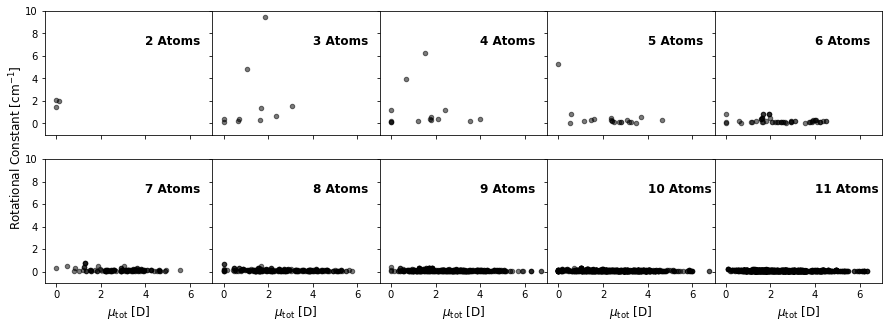

In [122]:
#.loc[df['Geometry Flag'] == 'N']

fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(15, 5),sharey=True,sharex=True)
#geom_flags = df['Geometry Flag']
#colours = {'Y':'#1A85FF', 'N':'#D41159'}
i=0
j=0
for num_atoms in np.arange(2,12,1):
    if i == 5:
        i=0
        j+=1
    if j==2:
        break
    num_atom_df = df.loc[df['# Atoms'] == num_atoms]
    num_atoms = num_atom_df.loc[num_atom_df['Geometry Flag'] == 'Y']['# Atoms'].values
    cmap = cm.get_cmap(plt.cm.jet, 11)
    norm = cm.colors.BoundaryNorm(np.arange(2,12,1), cmap.N)
    bounds = np.linspace(2.5,10.5,11)

    C = num_atom_df.loc[num_atom_df['Geometry Flag'] == 'Y']['C [cm-1]'].values

    Tot_DipMom = num_atom_df.loc[num_atom_df['Geometry Flag'] == 'Y']['mu_tot [D]'].values

    axs[j,i].scatter(Tot_DipMom,C,alpha=0.3,s=20,c='k',marker='o')
    
    axs[j,i].text(4,7,str(num_atoms[0])+' Atoms',fontsize=12,weight='bold')
    
    if j==1:
        axs[1,i].set_xlabel(r'$\mu_\mathrm{tot}$ [D]',fontsize=12)
    i+=1
    
axs[0,0].set_xlim(-0.5,7)
axs[0,0].set_ylim(-1,10)    
fig.text(0.09, 0.5, r'Rotational Constant [cm$^{-1}$]', va='center', rotation='vertical',fontsize=12)

plt.subplots_adjust(wspace=0.0)

plt.savefig(comp_loc+'1_BigData/Data Analysis/compare_DipMom_RotConstC.png')

plt.show()

## 5.1.5 Compare Symmetry Metric 

### 5.1.5.1 and Dipole Moments

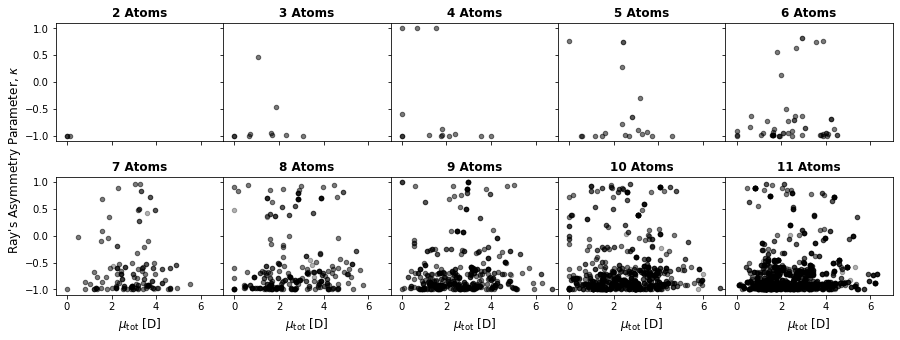

In [132]:
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(15, 5),sharey=True,sharex=True)

i=0
j=0
for num_atoms in np.arange(2,12,1):
    if i == 5:
        i=0
        j+=1
    if j==2:
        break
    num_atom_df = df.loc[df['# Atoms'] == num_atoms]
    num_atoms = num_atom_df.loc[num_atom_df['Geometry Flag'] == 'Y']['# Atoms'].values
    cmap = cm.get_cmap(plt.cm.jet, 11)
    norm = cm.colors.BoundaryNorm(np.arange(2,12,1), cmap.N)
    bounds = np.linspace(2.5,10.5,11)

    A = num_atom_df.loc[num_atom_df['Geometry Flag'] == 'Y']['A [cm-1]'].values
    B = num_atom_df.loc[num_atom_df['Geometry Flag'] == 'Y']['B [cm-1]'].values
    C = num_atom_df.loc[num_atom_df['Geometry Flag'] == 'Y']['C [cm-1]'].values
    
    k_param = (2*B-A-C)/(A-C)

    Tot_DipMom = num_atom_df.loc[num_atom_df['Geometry Flag'] == 'Y']['mu_tot [D]'].values

    axs[j,i].scatter(Tot_DipMom,k_param,alpha=0.3,s=20,c='k',marker='o',)
    
    axs[j,i].set_title(str(num_atoms[0])+' Atoms',fontsize=12,weight='bold')
    
    if j==1:
        axs[1,i].set_xlabel(r'$\mu_\mathrm{tot}$ [D]',fontsize=12)
    i+=1
    
axs[0,0].set_xlim(-0.5,7)
axs[0,0].set_ylim(-1.1,1.1)    
fig.text(0.08, 0.5, r"Ray's Asymmetry Parameter, $\kappa$", va='center', rotation='vertical',fontsize=12)


plt.subplots_adjust(wspace=0.0,hspace=0.3)

plt.savefig(comp_loc+'1_BigData/Data Analysis/compare_DipMom_kasymm_ALL.png')

plt.show()

### 5.1.5.2 and RMSD

In [ ]:
## Start here

## 5.1.6 Corner Plot of Geometry Metrics

## 5.1.7 Compare NumRotabaleBonds and RMSD Atoms Positions

In [ ]:
#use function in rdkit
#how does CREST rotate bonds, do bond lengths change?

## 5.1.8 Compare Error in Boltzmann pop at 298 K

In [133]:
df

,Formula,SMILES,# Atoms,Conf#/Rota#,Relative Energy [kJ/mol],RawFreq [cm-1],ScaledFreq [cm-1],Intensity,mu_a [D],mu_b [D],mu_c [D],mu_tot [D],mu_amu_bmu_c,A [cm-1],B [cm-1],C [cm-1],Geometry RMSD,Geometry Flag
0,C2H2,C#C,4,CONF1,0.000000,"[688.4955, 688.4955, 775.8896, 775.8896, 2092....","[667.2898385999999, 667.2898385999999, 751.992...","[0.0, 0.0, 101.0567, 101.0567, 0.0, 90.6391, 0.0]",2.000915e-07,2.119624e-07,0.000003,0.000003,1.109623e-19,0.000000,1.193039,1.193039,0.001305,Y
1,C2H2O2,O=CC=O,6,CONF1,0.000000,"[128.2724, 341.7855, 558.5713, 818.55, 1080.10...","[124.32161008, 331.2585066, 541.36730396, 793....","[35.1568, 53.4123, 0.0, 2.0934, 0.0, 0.0, 8.29...",-9.995060e-08,-1.000049e-07,-0.000010,0.000010,-9.695684e-20,1.870834,0.160806,0.148078,0.006117,Y
2,C2H2OS_1,C#CSO,6,CONF1,0.000000,"[176.974, 324.5001, 437.1243, 462.7268, 566.46...","[171.52320079999998, 314.50549692, 423.6608715...","[1.9957, 42.321, 59.2577, 24.9507, 61.913, 10....",5.581037e-01,6.441872e-01,-1.376839,1.619303,-4.950055e-01,0.675594,0.133525,0.112625,0.007609,Y
3,C2H2OS_2,O=CC=S,6,CONF1,0.000000,"[107.5151, 296.6725, 494.7942, 811.0193, 1042....","[104.20363492, 287.534987, 479.55453864, 786.0...","[17.3018, 18.5149, 6.0628, 19.0213, 3.3058, 51...",-1.104956e+00,-9.335503e-02,-0.000004,1.108893,-3.847521e-07,1.732895,0.096180,0.091123,0.011577,Y
4,C2H2O_1,C1=CO1,5,CONF1,0.000000,"[229.2692, 565.9187, 705.9046, 909.7995, 990.1...","[222.20770864, 548.4884040399999, 684.16273831...","[2.9425, 88.5051, 0.0, 63.1626, 6.8996, 17.822...",2.372292e+00,-1.543807e-03,-0.000220,2.372293,8.074442e-07,1.128473,0.899832,0.500633,0.004052,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5674,H5N2OPS,NP(N)(O)=S,10,ROTA16,0.092943,"[226.7113, 236.2019, 260.8023, 343.9865, 354.8...","[219.72859196, 228.92688148, 252.7695891599999...","[14.0529, 13.1778, 25.14, 3.4153, 63.3309, 48....",-2.929984e+00,-1.876646e-01,0.190036,2.942132,1.044919e-01,0.144513,0.087829,0.083185,0.021574,Y
5675,H5N2OPS,NP(N)(O)=S,10,ROTA10,0.143090,"[226.6095, 235.4049, 259.1879, 343.8866, 354.4...","[219.62992739999999, 228.15442908, 251.2049126...","[13.4902, 14.0157, 25.0132, 3.6689, 61.3996, 5...",-2.912476e+00,-4.013332e-01,0.105494,2.941890,1.233089e-01,0.144515,0.087824,0.083186,0.021341,Y
5676,H5N2OPS,NP(N)(O)=S,10,ROTA8,0.040433,"[226.587, 235.1242, 258.5889, 344.027, 353.300...","[219.6081204, 227.88237464, 250.62436188, 333....","[12.7281, 14.7424, 25.8892, 3.0567, 61.0737, 4...",-2.889070e+00,-4.537009e-01,0.315106,2.941405,4.130331e-01,0.144515,0.087830,0.083189,0.018614,Y
5677,H5N2OPS,NP(N)(O)=S,10,ROTA12,0.088217,"[226.7157, 236.1983, 260.7997, 343.9862, 354.8...","[219.73285643999998, 228.92339235999998, 252.7...","[14.0513, 13.1749, 25.137, 3.4132, 63.333, 48....",-2.930070e+00,-1.867935e-01,0.189701,2.942140,1.038268e-01,0.144513,0.087829,0.083185,0.021683,Y
